In [1]:
import tensorflow as tf
import tensorflow.keras as tk

import numpy as np

import matplotlib.pyplot as plt

2022-09-15 20:33:42.888795: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-15 20:33:42.892705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 20:33:42.892719: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [160]:
from tqdm import trange
from collections import defaultdict
import pickle

### Parameters

In [2]:
past_stepsize = 1
past_windowsize = 20
pred_stepsize = 10
pred_windowsize = 10

### Functions

In [3]:
def pos_encoder(pos, freq=400, d=4):
    pos_enc = np.zeros([pos.shape[0], d], dtype=np.float32)
    for i in range(d):
        if i % 2 == 0:
            pos_enc[:, i] = np.sin(pos / (freq ** (i / d)))
        else:
            pos_enc[:, i] = np.cos(pos / (freq ** (i / d)))
    return pos_enc

def data_loader(file_prefix, phase):
    # past data column: ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
    data = np.load(file_prefix + 'dataset_past_' + str(phase) + '.npy', mmap_mode='r')
    data = data.astype('float32')
    past = data[:,  -past_stepsize*(past_windowsize-1)-1::past_stepsize]
    past = past.astype('float32')
    map_data = np.load(file_prefix + 'dataset_map_' + str(phase) + '.npy')
    map_data = map_data.astype('float32')
    pred = np.load(file_prefix + 'dataset_pred_' + str(phase) + '.npy')
    if pred_stepsize == 10:
        pred = pred[:, 1::2]
    pred = pred.astype('float32')
    dist = np.load(file_prefix + 'dataset_dist_' + str(phase) + '.npy')

    return past, map_data, pred, dist

    return past, map_data, pred, dist

### Load Trained Model

In [4]:
results_path = './results/att_fwpos_20220602-150355/'
model_path = results_path+'model_pb/'
model = tk.models.load_model(model_path)

2022-09-15 20:33:44.875673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 20:33:44.875743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-15 20:33:44.875776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-15 20:33:44.875809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-09-15 20:33:44.875841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Load data for Test

In [5]:
file_prefix = '../data/hatci_clinic/1st_TD_matched/dataset_1/'
data_past, data_map, data_pred, data_dist = data_loader(file_prefix, 'test')

# data scale
past_max = np.load(results_path+'evaluations/past_max.npy')
scaled_data_past = data_past/past_max
map_max = np.load(results_path+'evaluations/map_max.npy')
scaled_data_map = data_map/map_max
pred_max = np.load(results_path+'evaluations/pred_max.npy')
scaled_data_pred = data_pred/pred_max

In [398]:
legends = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
legends2 = ['radius', 'slope', 'property', 'type']

In [397]:
np.min(scaled_data_past[:,0,1])

-0.7361876

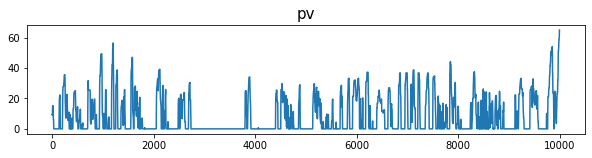

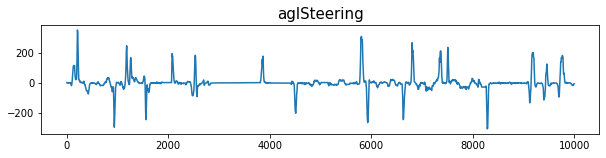

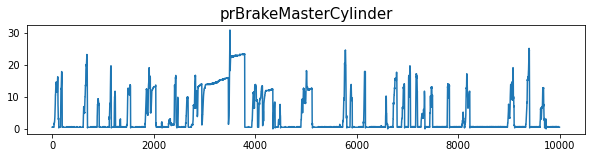

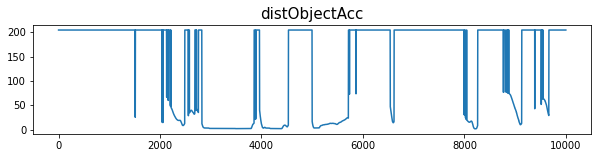

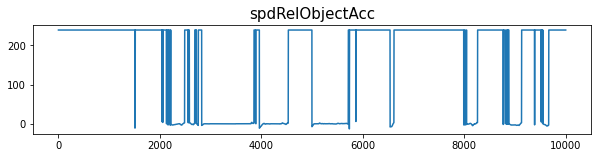

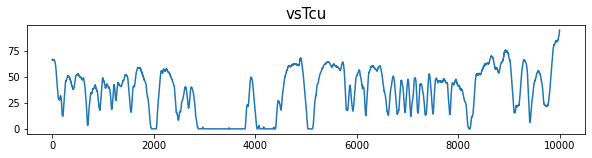

In [393]:
for i in range(6):
    plt.figure(figsize=(10,2))
    plt.title(legends[i], fontsize=15)
    plt.plot(data_past[:10000,0,i])
    plt.show()
    

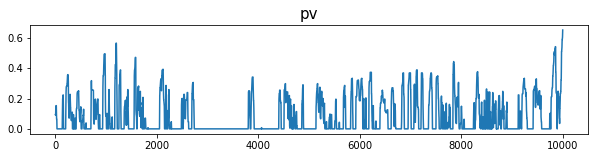

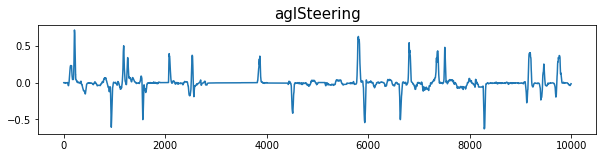

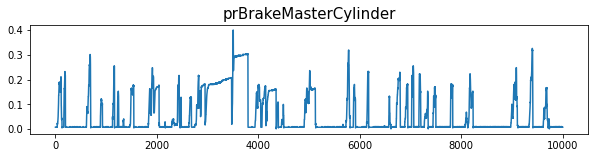

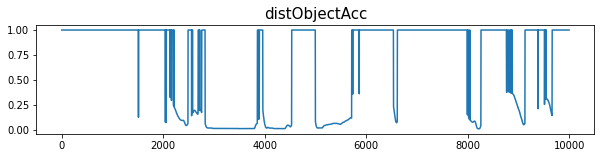

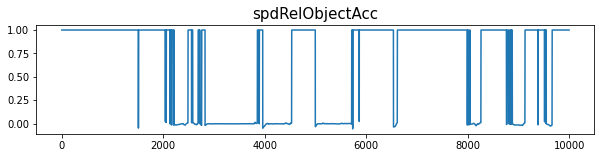

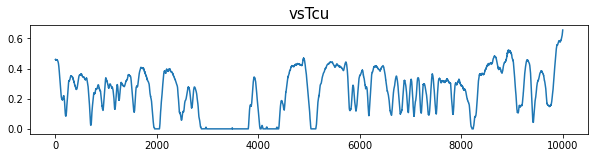

In [391]:
for i in range(6):
    plt.figure(figsize=(10,2))
    plt.title(legends[i], fontsize=15)
    plt.plot(scaled_data_past[:10000,0,i])
    plt.show()

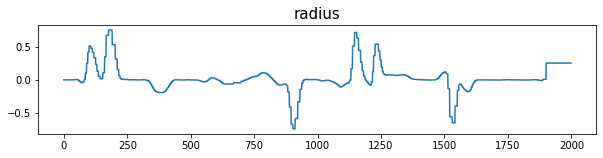

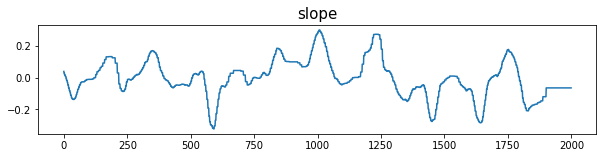

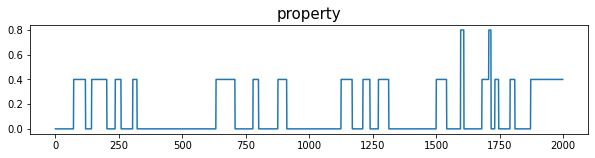

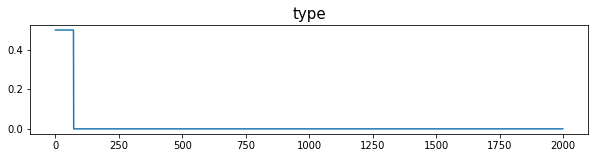

In [401]:
for i in range(4):
    plt.figure(figsize=(10,2))
    plt.title(legends2[i], fontsize=15)
    plt.plot(scaled_data_map[:2000,0,i])
    plt.show()

In [6]:
print(past_max)
print(pred_max)

[ 99.60784 490.5      76.8     204.6     239.4     144.375  ]
[144.375]


### Visualize dataset

In [7]:
print(data_past.shape)
print(type(data_past))

(351265, 20, 6)
<class 'numpy.ndarray'>


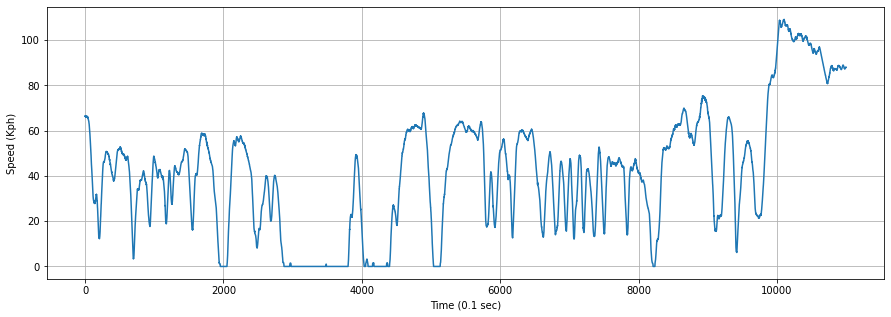

In [8]:
plt.figure(figsize=(15,5))
plt.plot(data_past[:11000,0,-1:])
plt.ylabel('Speed (Kph)')
plt.xlabel('Time (0.1 sec)')
plt.grid()

### 1. Model analysis w.r.t a sample

In [9]:
print(np.max(scaled_data_past))
print(np.min(scaled_data_past))

1.0
-0.7361876


In [10]:
# Parameters
# Sample index
# idx = 246289
idx = np.random.choice(300000, 1)[0]

output_time_steps=10
pos_enc_past = tf.tile(tf.expand_dims(pos_encoder(np.arange(10), 40), axis=0), [1, 1, 1])
pos_enc_fwd = tf.tile(tf.expand_dims(pos_encoder(np.arange(100)), axis=0), [1, 1, 1])

# Data Sampling
x_past = scaled_data_past[idx:idx+1]
x_forward = scaled_data_map[idx:idx+1]
y = scaled_data_pred[idx:idx+1]
print(f'Past data shape: {x_past.shape}')
print(f'Forward data shape: {x_forward.shape}')
print(f'Prediction target data shape: {y.shape}')

Past data shape: (1, 20, 6)
Forward data shape: (1, 100, 4)
Prediction target data shape: (1, 10, 1)


past data
- pv
- aglSteering
- prBrake
- distObject
- spdObject
- speed

#### 1.1 Inference

In [11]:
output = model(x_past, x_forward, pos_enc_past, pos_enc_fwd)

mse
[[  0.5195]
 [  0.2915]
 [  1.077 ]
 [  0.0681]
 [  1.0436]
 [  1.5548]
 [  1.961 ]
 [  6.1875]
 [ 98.9481]
 [182.5444]]
mean =  29.41955
mae
[[ 0.7208]
 [ 0.5399]
 [ 1.0378]
 [ 0.2609]
 [ 1.0216]
 [ 1.2469]
 [ 1.4004]
 [ 2.4875]
 [ 9.9473]
 [13.5109]]
mean =  3.2173831


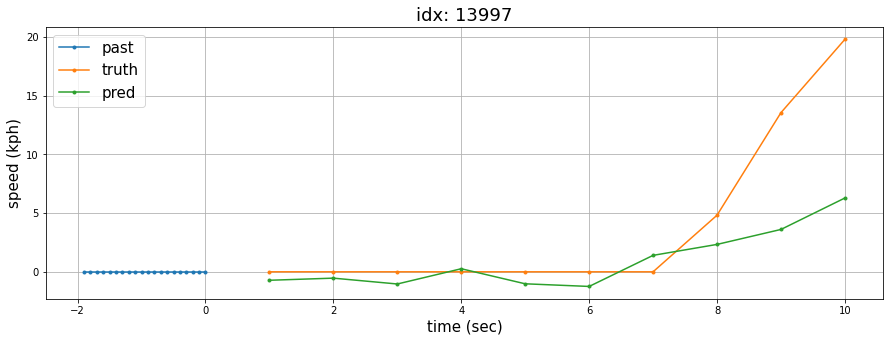

In [12]:
# Error evaluation
error = pred_max * (y-output)
mse = np.mean(np.square(error), axis=0)
mae = np.mean(np.abs(error), axis=0)

np.set_printoptions(precision=4, suppress=True)
print("mse")
print(mse)
print("mean = ", np.mean(mse))
print("mae")
print(mae)
print("mean = ", np.mean(mae))

# Results Visualize
x1 = np.arange(1, 21)*0.1 - 2
x2 = np.arange(1, 11)
plt.figure(figsize=(15,5))
plt.title('idx: %s'%format(idx), fontsize=18)
plt.plot(x1, (x_past*past_max)[0, :, -1], '.-', label='past')
plt.plot(x2, y[0]*pred_max[0], '.-', label='truth')
plt.plot(x2, output[0]*pred_max, '.-', label='pred')
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('speed (kph)', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

# LRP Implementation

In [13]:
import tensorflow.compat.v1 as tf1
from tensorflow.python.ops import nn_ops

def get_act_encoder(encoder, x, collect_name='conv'):
    for i in range(len(encoder.convs)):
        x = encoder.convs[i](x)
        x = encoder.relu(x)
        tf1.add_to_collection(collect_name, x)
    return x

def get_act_attention(attention, query, feature, collect_name='att'):
    key = attention.relu(attention.dense1(feature))
    tf1.add_to_collection(collect_name+'_key', key)
    key = attention.relu(attention.dense2(key))
    tf1.add_to_collection(collect_name+'_key', key)
    
    v1 = attention.u_e(key)
    v2 = tf.expand_dims(attention.w_e(query), axis=2)
    tf1.add_to_collection(collect_name+'_v1', v1)
    tf1.add_to_collection(collect_name+'_v2', v2)
    
    e_t = tf.squeeze(attention.v_e(attention.tanh(v1 + v2)), axis=-1)
    tf1.add_to_collection(collect_name+'_e', e_t)
    alpha_t = attention.softmax(e_t)
    
    return alpha_t
    

def get_act_model(model, x_past, x_forward, pos_enc_past, pos_enc_fwd, training=False):
    x_forward = tf.expand_dims(x_forward, axis=1)
    pos_enc_fwd = tf.expand_dims(pos_enc_fwd, axis=1)
    
    past_enc = get_act_encoder(model.enc_past, x_past, collect_name='past_conv')

    code_past = model.relu(model.dense1(model.flatten(past_enc)))
    code_past = tf.tile(tf.expand_dims(code_past, axis=1), [1, model.output_time_steps, 1])
    tf1.add_to_collection('code_past_enc', tf.concat([code_past, pos_enc_past], axis=-1))

    query = model.relu(model.dense2(tf.concat([code_past, pos_enc_past], axis=-1)))  # shape: [-1, self.output_time_steps, k+self.output_time_steps]
    tf1.add_to_collection('query', query)
    
    alpha = get_act_attention(model.spatial_att, query, tf.concat([x_forward, pos_enc_fwd], axis=-1))  # shape: [-1, self.output_time_steps, forward_length]
    tf1.add_to_collection('alpha', alpha)
    
    att_feature = tf.expand_dims(alpha, axis=3) * x_forward  # shape: [-1, self.output_time_steps, forward_length, forward_channel]
    tf1.add_to_collection('att_feature', att_feature)
    forward_enc = get_act_encoder(model.enc_forward, att_feature, collect_name='forward_conv')
    code_att = model.relu(model.dense3(tf.reshape(forward_enc, [-1, model.output_time_steps, 94 * 32])))  # shape: [-1, self.output_time_steps, m]
    
    code = tf.concat([query, code_att], axis=-1)  # shape: [-1, self.output_time_steps, k+m]
    tf1.add_to_collection('concat_code', code)
    
    x = model.relu(model.dense4(code))  # shape: [-1, self.output_time_steps, 1]
    tf1.add_to_collection('dense4', x)
    
    output = model.tanh(model.dense5(x)) + x_past[:, -1:, -1:]
    tf1.add_to_collection('diff', model.tanh(model.dense5(x)))
    
    return output

In [14]:
model.output_time_steps = 10
tf1.reset_default_graph()
get_act_model(model, x_past, x_forward, pos_enc_past, pos_enc_fwd)

<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
array([[[-0.005 ],
        [-0.0037],
        [-0.0072],
        [ 0.0018],
        [-0.0071],
        [-0.0086],
        [ 0.0097],
        [ 0.0162],
        [ 0.025 ],
        [ 0.0435]]], dtype=float32)>

In [15]:
tf1.get_default_graph().get_all_collection_keys()

['past_conv',
 'code_past_enc',
 'query',
 'att_key',
 'att_v1',
 'att_v2',
 'att_e',
 'alpha',
 'att_feature',
 'forward_conv',
 'concat_code',
 'dense4',
 'diff']

In [56]:
class RelevancePropagation(object):
    
    def __init__(self):
        self.epsilon = 1e-9
        
    def rp_dense_out(self, x, w, r):
        
        r_p = self.rp_dense(x, w, tf.maximum(r, 0))
        r_n = self.rp_dense(x, -w, tf.abs(tf.minimum(r, 0)))
        
        return r_p + r_n  
    
    def rp_dense_in(self, x, w, r):
        w_2 = tf.pow(w, 2)
        sum_w_2 = tf.reduce_sum(w_2, axis=0)
        return tf.matmul(r, tf.transpose(w_2/sum_w_2))
        
    def rp_dense_neg_parallel(self, x, w, r):
        rel_list = []
        for i in range(10):
            for j in range(100):
                tmp_x = x[i:i+1,j,:]
                tmp_w = tf.transpose(tf.sign(tmp_x))*w
                tmp_x = tmp_x * tf.sign(tmp_x)
                tmp_rel = self.rp_dense(tmp_x, tmp_w, r[i,j])
                rel_list.append(tmp_rel)
                
        return tf.reshape(tf.concat(rel_list, axis=0), (10,100,-1))
        
        
    def rp_dense(self, x, w, r):
        w_pos = tf.maximum(w, 0)
        z = tf.matmul(x, w_pos)
        z = z + self.epsilon
        s = r / z
        c = tf.matmul(s, tf.transpose(w_pos))
        return c * x
    
    def rp_conv(self, x, kernel, r, strides=1, padding='VALID'):
        w_p = tf.maximum(0., kernel)
        z = nn_ops.conv1d(x, w_p, strides, padding) + 1e-10
        s = r / z
        c = tf.nn.conv1d_transpose(s, w_p, output_shape=tf.shape(x), strides=strides, padding=padding)
        return x * c
    
    def rp_conv_parallel(self, x, kernel, r, strides=1, padding='VALID'):
        w_p = tf.maximum(0., kernel)
        rel_list = []
        for i in range(x.shape[1]):
            x2 = x[:,i]
            r2 = r[:,i]
            z = nn_ops.conv1d(x2, w_p, strides, padding) + 1e-10
            s = r2 / z
            c = tf.nn.conv1d_transpose(s, w_p, output_shape=tf.shape(x2), strides=strides, padding=padding)
            rel_list.append( x2 * c )
        return tf.concat(rel_list, axis=0)

    def rp_conv_input(self, x, kernel, r, strides=1, padding='VALID', lowest=-1., highest=1.):
        w_p = tf.maximum(0., kernel)
        w_n = tf.minimum(0., kernel)
        
        L = tf.ones_like(x, tf.float32) * lowest
        H = tf.ones_like(x, tf.float32) * highest
        
        z_o = nn_ops.conv1d(x, kernel, strides, padding)
        z_p = nn_ops.conv1d(L, w_p, strides, padding)
        z_n = nn_ops.conv1d(H, w_n, strides, padding)
        
        z = z_o - z_p - z_n + 1e-10
        s = r / z
        
        c_o =  tf.nn.conv1d_transpose(s, kernel, output_shape=tf.shape(x), strides=strides, padding=padding)
        c_p =  tf.nn.conv1d_transpose(s, w_p, output_shape=tf.shape(x), strides=strides, padding=padding)
        c_n =  tf.nn.conv1d_transpose(s, w_n, output_shape=tf.shape(x), strides=strides, padding=padding)
        
        return x * c_o - L * c_p - H * c_n
    
    def rp_conv_input_parallel(self, x, kernel, r, strides=1, padding='VALID', lowest=-1., highest=1.):
        w_p = tf.maximum(0., kernel)
        w_n = tf.minimum(0., kernel)
        
        rel_list = []
        for i in range(x.shape[1]):
            x2 = x[:,i]
            r2 = r[:,i]
        
            L = tf.ones_like(x2, tf.float32) * lowest
            H = tf.ones_like(x2, tf.float32) * highest

            z_o = nn_ops.conv1d(x2, kernel, strides, padding)
            z_p = nn_ops.conv1d(L, w_p, strides, padding)
            z_n = nn_ops.conv1d(H, w_n, strides, padding)

            z = z_o - z_p - z_n + 1e-10
            s = r2 / z

            c_o =  tf.nn.conv1d_transpose(s, kernel, output_shape=tf.shape(x2), strides=strides, padding=padding)
            c_p =  tf.nn.conv1d_transpose(s, w_p, output_shape=tf.shape(x2), strides=strides, padding=padding)
            c_n =  tf.nn.conv1d_transpose(s, w_n, output_shape=tf.shape(x2), strides=strides, padding=padding)

            rel_list.append(x2 * c_o - L * c_p - H * c_n)
        return tf.concat(rel_list, axis=0)
    

    def run_lrp_input(self, prnt=False):    
        '''output to concat'''
        tmp_x = tf1.get_collection('dense4')[0]
        tmp_w = model.dense5.get_weights()[0]
        tmp_r = tf1.get_collection('diff')[0]
        rel = self.rp_dense_out(tmp_x, tmp_w, tmp_r)
        
        tmp_x = tf1.get_collection('concat_code')[0]
        tmp_w = model.dense4.get_weights()[0]
        rel2 = self.rp_dense(tmp_x, tmp_w, rel)
        
        '''concat to att_out'''
        tmp_x = tf1.get_collection('forward_conv')[-1]
        tmp_w = model.dense3.get_weights()[0]
        rel3a = self.rp_dense(tf.reshape(tmp_x, (10,-1)) , tmp_w, rel2[:,:,32:])
        
        conv_x = tf1.get_collection('forward_conv')[-2]
        conv_w = model.enc_forward.convs[-1].get_weights()[0]
        rel4a = self.rp_conv_parallel(conv_x, conv_w, tf.reshape(tf.expand_dims(rel3a, axis=0), (-1, model.output_time_steps, 94, 32)))
        
        conv_x = tf1.get_collection('forward_conv')[-3]
        conv_w = model.enc_forward.convs[-2].get_weights()[0]
        rel5a = self.rp_conv_parallel(conv_x, conv_w, tf.reshape(tf.expand_dims(rel4a, axis=0), (-1, model.output_time_steps, 96, 32)))
            
        conv_x = tf1.get_collection('att_feature')[0]
        conv_w = model.enc_forward.convs[-3].get_weights()[0]
        rel6a = self.rp_conv_input_parallel(conv_x, conv_w, tf.reshape(tf.expand_dims(rel5a, axis=0), (-1, model.output_time_steps, 98, 32)))
        
        '''att_out to input'''
        # alpha * x_forward
        alpha = tf1.get_collection('alpha')[0]
        attention = model.spatial_att
        # softmax
        v1 = tf1.get_collection('att_v1')[0]
        v2 = tf1.get_collection('att_v2')[0]
        tmp_x = attention.tanh(v1 + v2)[0]
        tmp_w = attention.v_e.get_weights()[0]
       
        rel6a = tf.expand_dims(tf.reduce_sum(rel6a, axis=2), axis=2)
        rel7a = self.rp_dense_neg_parallel(tmp_x, tmp_w, rel6a)
        
        v1 = tf.tile(v1, [1,10,1,1])
        v2 = tf.tile(v2, [1,1,100,1])
        
        rel_key = rel7a * v1/(v1+v2)
        rel_key = tf.reduce_sum(rel_key, axis=1)
        rel_query = rel7a * v2/(v1+v2)
        rel_query = tf.reduce_sum(rel_query, axis=2)
    
        
        '''att to key'''
        tmp_x = tf1.get_collection('att_key')[-1]
        tmp_w = attention.u_e.get_weights()[0]
        rel_key2 = self.rp_dense_out(tmp_x, tmp_w, rel_key)
        
        tmp_x = tf1.get_collection('att_key')[-2]
        tmp_w = attention.dense2.get_weights()[0]
        rel_key3 = self.rp_dense(tmp_x, tmp_w, rel_key2)
        
        tmp_x = tf.expand_dims(x_forward, axis=1)
        tmp_pos_enc_fwd = tf.expand_dims(pos_enc_fwd, axis=1)
        tmp_x = tf.concat([tmp_x, tmp_pos_enc_fwd], axis=-1)
        tmp_w = attention.dense1.get_weights()[0]
        rel_forward = self.rp_dense_in(tmp_x, tmp_w, rel_key3)
        
        '''att to query''' 
        tmp_x = tf1.get_collection('query')[0]
        tmp_w = attention.w_e.get_weights()[0]
        rel_query2 = self.rp_dense(tmp_x, tmp_w, rel_query)
        
        '''concat to code'''
        tmp_x = tf1.get_collection('code_past_enc')[0]
        tmp_w = model.dense2.get_weights()[0]
        rel3 = self.rp_dense(tmp_x, tmp_w, rel2[:,:,:32]+rel_query2)
        rel_code = tf.reduce_sum(rel3[:], axis=1)
        
        '''code to input'''
        tmp_x = tf1.get_collection('past_conv')[-1]
        tmp_w = model.dense1.get_weights()[0]
        rel4 = self.rp_dense(tf.reshape(tmp_x, (1,-1)), tmp_w, rel_code[:,:32])
        rel4 = tf.reshape(rel4, (1, 14, 32))

        conv_x = tf1.get_collection('past_conv')[-2]
        conv_w = model.enc_past.convs[-1].get_weights()[0]
        rel5 = self.rp_conv(conv_x, conv_w, rel4)
        
        conv_x = tf1.get_collection('past_conv')[-3]
        conv_w = model.enc_past.convs[-2].get_weights()[0]
        rel6 = self.rp_conv(conv_x, conv_w, rel5)
        
        conv_x = x_past
        conv_w = model.enc_past.convs[-3].get_weights()[0]
        rel_input = self.rp_conv_input(conv_x, conv_w, rel6)
        
        past_rel = tf.reduce_sum(rel_input)
        forward_rel = tf.reduce_sum(rel_forward)
        
        if prnt:
            print("[Value]\nPast Relevance: %.6f, Forward Relevance: %.6f"%(past_rel, forward_rel))
            print("[Percentage]\nPast Relevance: %.2f, Forward Relevance: %.2f"%(100*past_rel/(past_rel+forward_rel), 100*forward_rel/(past_rel+forward_rel)))

        return rel_input.numpy(), np.squeeze(rel_forward.numpy(), 0)


        

    

In [57]:
lrp = RelevancePropagation()
rel_input, rel_forward = lrp.run_lrp_input(prnt=True)
# print('check the sum of relev_input: ', tf.reduce_sum(rel_input))
# print('check the sum of relev_forward: ', tf.reduce_sum(rel_forward))
print('check the shape of relev_input: ', rel_input.shape)
print('check the shape of relev_forward: ', rel_forward.shape)
msize = rel_input[0].numpy()

[Value]
Past Relevance: 0.887399, Forward Relevance: 0.144703
[Percentage]
Past Relevance: 85.98, Forward Relevance: 14.02
check the shape of relev_input:  (1, 20, 6)
check the shape of relev_forward:  (1, 100, 8)


mse
[[  0.5195]
 [  0.2915]
 [  1.077 ]
 [  0.0681]
 [  1.0436]
 [  1.5548]
 [  1.961 ]
 [  6.1875]
 [ 98.9481]
 [182.5444]]
mean =  29.41955
mae
[[ 0.7208]
 [ 0.5399]
 [ 1.0378]
 [ 0.2609]
 [ 1.0216]
 [ 1.2469]
 [ 1.4004]
 [ 2.4875]
 [ 9.9473]
 [13.5109]]
mean =  3.2173831


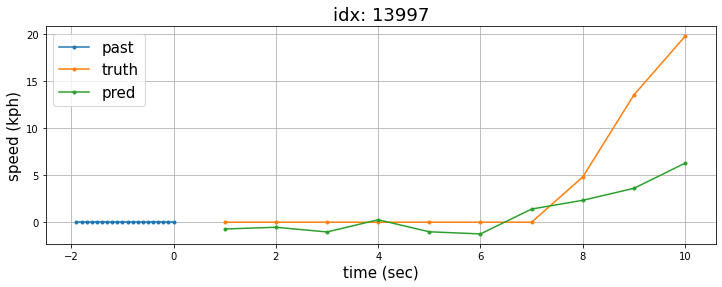

In [18]:
# Error evaluation
error = pred_max * (y-output)
mse = np.mean(np.square(error), axis=0)
mae = np.mean(np.abs(error), axis=0)

np.set_printoptions(precision=4, suppress=True)
print("mse")
print(mse)
print("mean = ", np.mean(mse))
print("mae")
print(mae)
print("mean = ", np.mean(mae))

# Results Visualize
x1 = np.arange(1, 21)*0.1 - 2
x2 = np.arange(1, 11)
plt.figure(figsize=(12,4))
plt.title('idx: %s'%format(idx), fontsize=18)
plt.plot(x1, (x_past*past_max)[0, :, -1], '.-', label='past')
plt.plot(x2, y[0]*pred_max[0], '.-', label='truth')
plt.plot(x2, output[0]*pred_max, '.-', label='pred')
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('speed (kph)', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

## LRP visualization

In [19]:
msize = rel_input[0].numpy()
x_past.shape
# print(rel_input[0])

(1, 20, 6)

In [20]:
1e4*msize[:,0]

array([ 0.3298,  1.0867,  2.4117,  3.7722,  4.9554,  5.6109,  6.0964,
        6.5761,  7.0904,  7.2844,  7.3387,  7.4562,  7.4019,  7.0939,
       10.2893,  7.5655,  9.8027,  5.2298,  4.0184,  1.389 ],
      dtype=float32)

In [21]:
cmap_list = ['Reds', 'Oranges', 'Greens', 'Blues','Purples', 'Greys']
c_list = ['r' ,'coral', 'limegreen', 'dodgerblue', 'mediumpurple', 'gray']

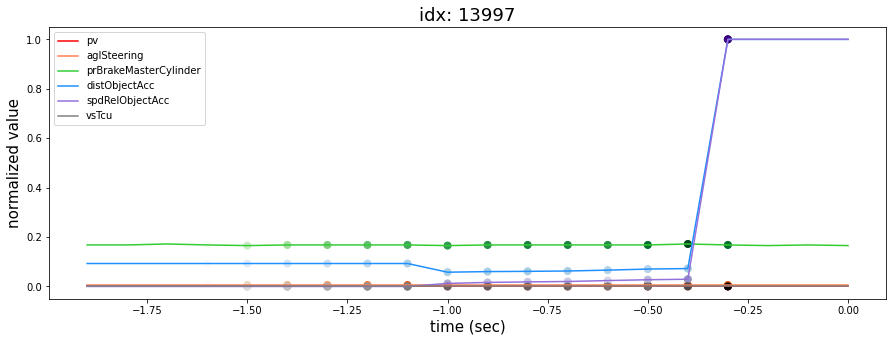

In [22]:
plt.figure(figsize=(15,5))

# plt.plot(x1, x_past[0], '.-')
legends = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']

for i in range(6):
    plt.plot(x1, x_past[0,:,i], '-', c=c_list[i], label=legends[i])
    plt.scatter(x1[3:-3], x_past[0,3:-3,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[3:-3,i])
    
plt.title('idx: %s'%format(idx), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(loc='best')

In [23]:
input_vars = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']

<BarContainer object of 6 artists>

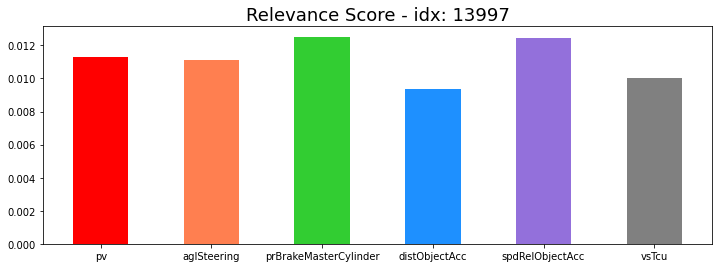

In [24]:
plt.figure(figsize=(12,4))
plt.title('Relevance Score - idx: %s'%format(idx), fontsize=18)
plt.bar(input_vars, tf.reduce_sum(rel_input[0], axis=0), color=c_list, width=0.5)

In [25]:
proto_indices = np.array([206719, 245247, 242974, 19816, 183602, 258237, 155661, 16503, 151977, 182308, 147410, 339701, 80710, 100287, 308485, 180777, 306122, 123046, 219143, 328217, 319560, 86747,
                          257775, 348141, 48825, 86695, 281289, 125678, 342719, 172892])


In [26]:
bs = 300 # batch size
code_list = []

for i in range(351265//bs):
    x_past = scaled_data_past[i*bs:(i+1)*bs]
    code_past = model.relu(model.dense1(model.flatten(model.enc_past(x_past))))
    code_list.append(code_past)
    
code_past_all = np.vstack(code_list)
print(code_past_all.shape)

(351000, 32)


In [27]:
normalized_code = code_past_all / np.linalg.norm(code_past_all, axis=1)[:, np.newaxis]

In [28]:
from sklearn.metrics.pairwise import linear_kernel

feature_kernel = np.power(linear_kernel(normalized_code, normalized_code[proto_indices]), 30)

In [29]:
n_cluster = 25
proto_class = np.argmax(feature_kernel[:,:n_cluster], axis=1)

(array([68712., 37630., 55131., 33804., 25997., 31039., 19952., 37344.,
        20665., 20726.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

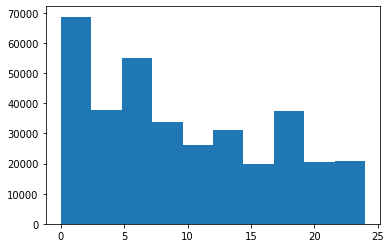

In [30]:
plt.hist(proto_class)

----

----

### 실행 ㄴㄴ

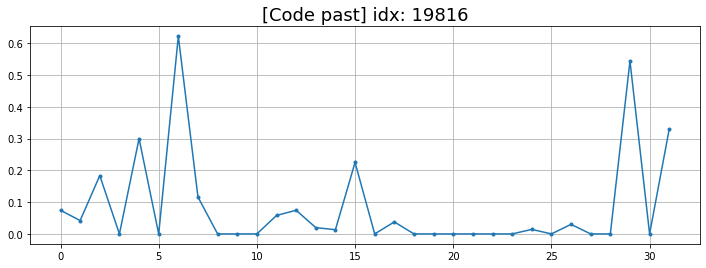

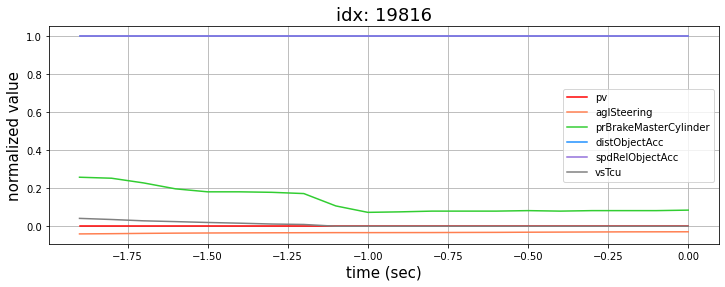

In [31]:
proto_group = proto_class[idx]
tmp_indices = np.where(proto_class==proto_group)[0]

''' prototype code_past 출력 및 input 관찰 '''

proto_idx = proto_indices[proto_group]

plt.figure(figsize=(12,4))
plt.title('[Code past] idx: %s'%format(proto_idx), fontsize=18)
plt.plot(normalized_code[proto_idx], '.-')
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
x_past = scaled_data_past[proto_idx]
for i in range(6):
    plt.plot(x1, x_past[:,i], '-',c=c_list[i])
#     plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])

plt.title('idx: %s'%format(proto_idx), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()

In [103]:
sample_tmp_indices = np.random.choice(tmp_indices, 100, replace=False)

In [104]:
%%time

rel_past_list = []
rel_forward_list = []

for i in trange(100):
    tf1.reset_default_graph()
    idx = sample_tmp_indices[i]
    
    output_time_steps=10
    pos_enc_past = tf.tile(tf.expand_dims(pos_encoder(np.arange(10), 40), axis=0), [1, 1, 1])
    pos_enc_fwd = tf.tile(tf.expand_dims(pos_encoder(np.arange(100)), axis=0), [1, 1, 1])

    # Data Sampling
    x_past = scaled_data_past[idx:idx+1]
    x_forward = scaled_data_map[idx:idx+1]
    y = scaled_data_pred[idx:idx+1]
    
    get_act_model(model, x_past, x_forward, pos_enc_past, pos_enc_fwd)
    lrp = RelevancePropagation()
    sample_rel_input, sample_rel_forward = lrp.run_lrp_input()
    rel_past_list.append(sample_rel_input)
    rel_forward_list.append(sample_rel_forward)
    
    del lrp
    tf1.reset_default_graph()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]

CPU times: user 1min 16s, sys: 1 s, total: 1min 17s
Wall time: 1min 13s


In [105]:
rel_past_np = np.vstack(rel_past_list)
rel_forward_np = np.vstack(rel_forward_list)
print(rel_past_np.shape)
print(rel_forward_np.shape)
rel_past_sum = np.sum(rel_past_np, axis=1)
rel_past_sum = rel_past_sum/np.linalg.norm(rel_past_sum, axis=1)[:,np.newaxis]
np.linalg.norm(rel_past_sum, axis=1)


tar_past_sum = tf.reduce_sum(rel_input[0], axis=0),
tar_past_sum = (tar_past_sum/np.linalg.norm(tar_past_sum, axis=1)[:,np.newaxis])[0]


(100, 20, 6)
(100, 100, 8)


<BarContainer object of 6 artists>

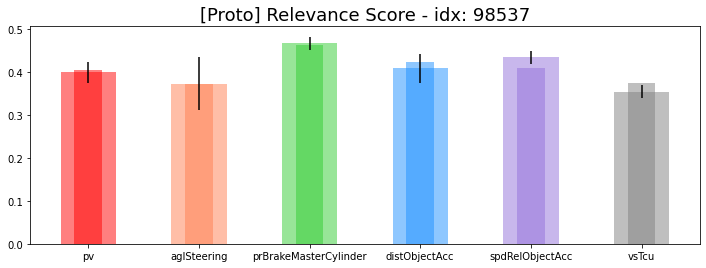

In [106]:
# rel_past_sum = np.sum(rel_past_np, axis=1)

plt.figure(figsize=(12,4))
plt.title('[Proto] Relevance Score - idx: %s'%format(idx), fontsize=18)
plt.bar(input_vars, np.mean(rel_past_sum, axis=0), yerr=np.std(rel_past_sum, axis=0) ,color=c_list, width=0.5, alpha=0.5)
plt.bar(input_vars, tar_past_sum, color=c_list, width=0.25, alpha=0.5)

In [118]:

# rel_past_dict = defaultdict()
# rel_forward_dict = defaultdict()

rel_past_dict = dict()
rel_forward_dict = dict()

rel_past_avg_list = []
rel_past_std_list = []

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


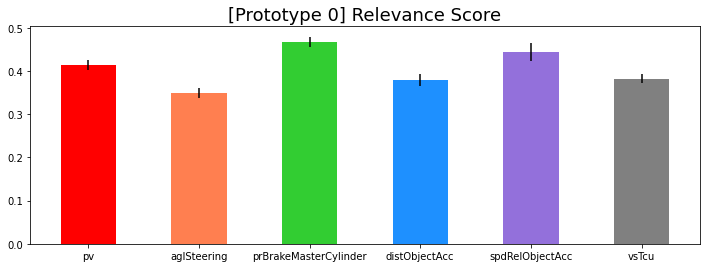

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


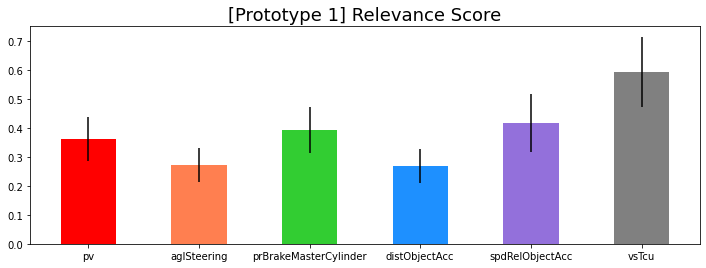

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


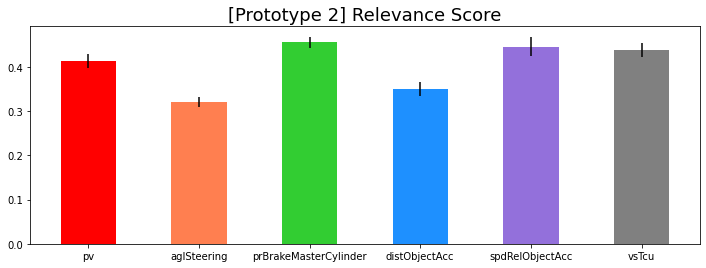

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


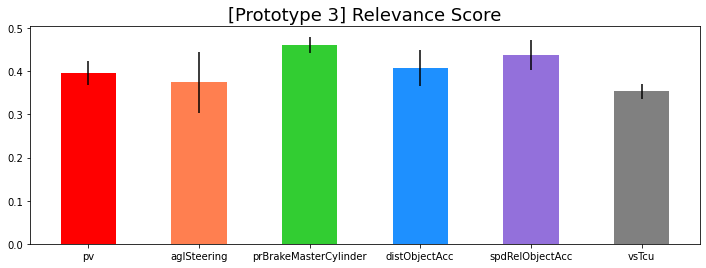

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


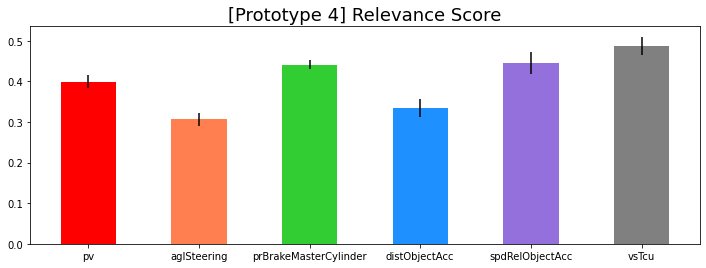

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


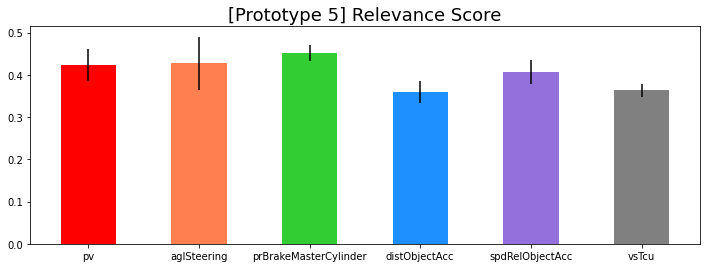

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


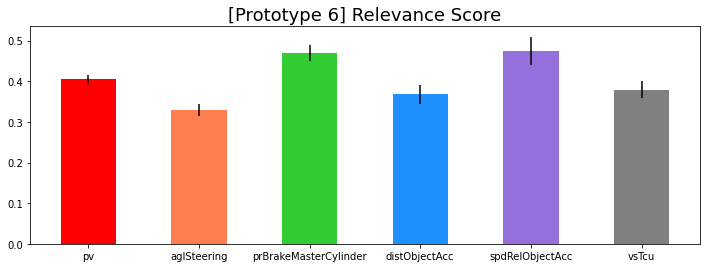

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


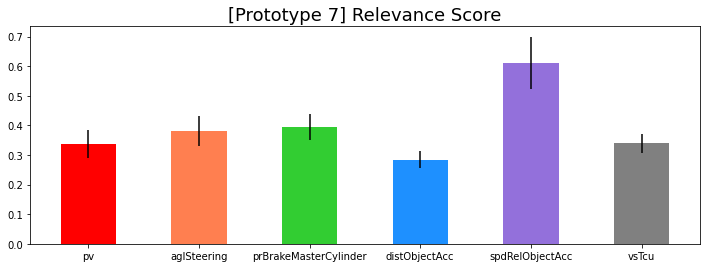

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


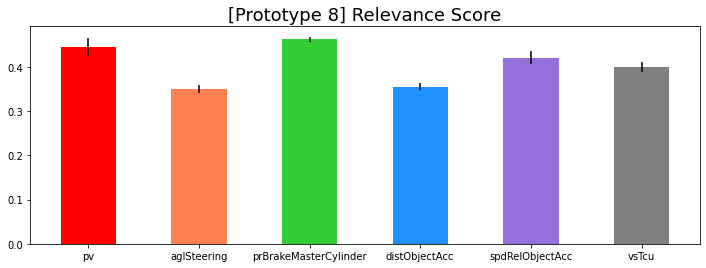

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]
/home/wonjoon/anaconda3/envs/hyundai/lib/python3.7/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/wonjoon/anaconda3/envs/hyundai/lib/python3.7/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


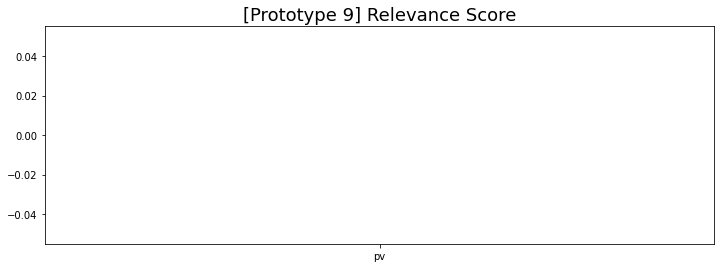

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


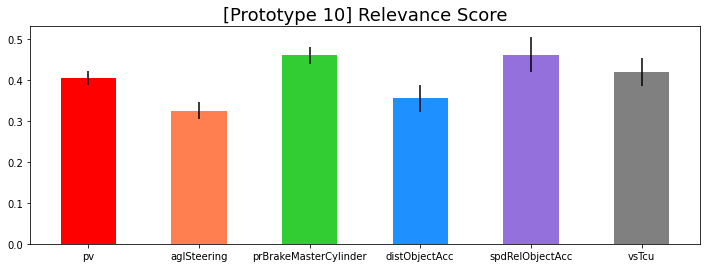

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]
/home/wonjoon/anaconda3/envs/hyundai/lib/python3.7/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/wonjoon/anaconda3/envs/hyundai/lib/python3.7/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


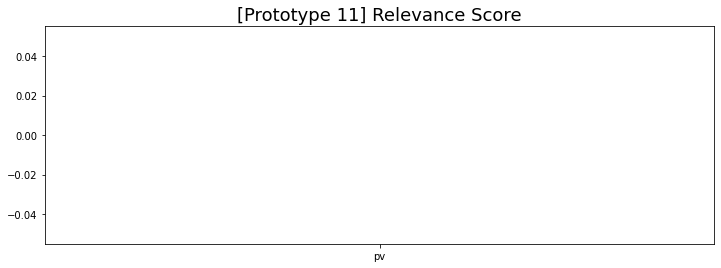

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


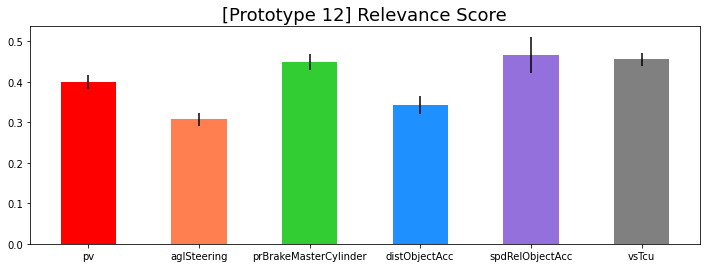

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


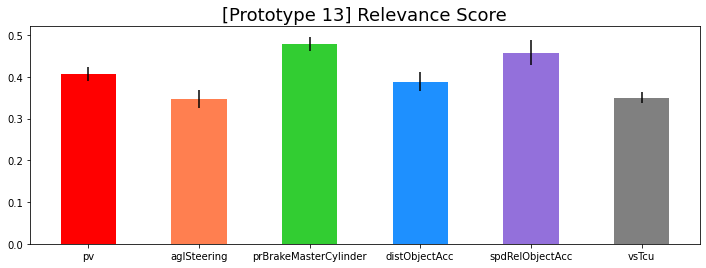

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


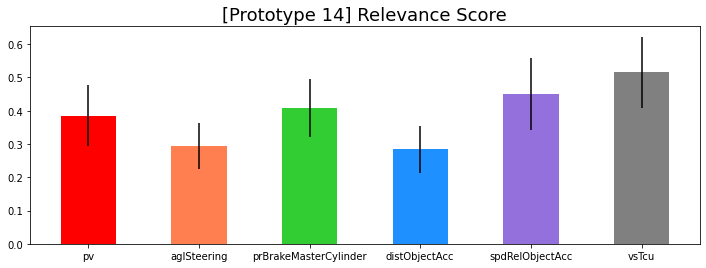

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


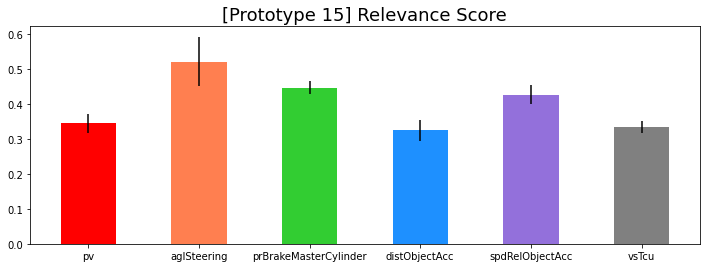

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


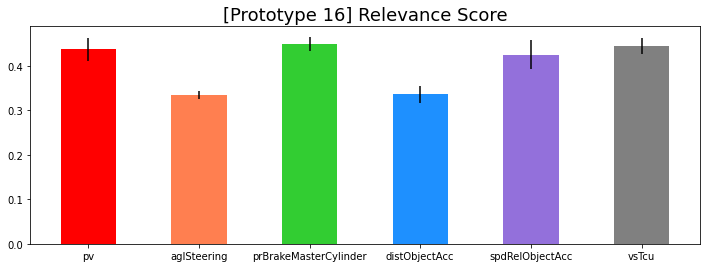

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


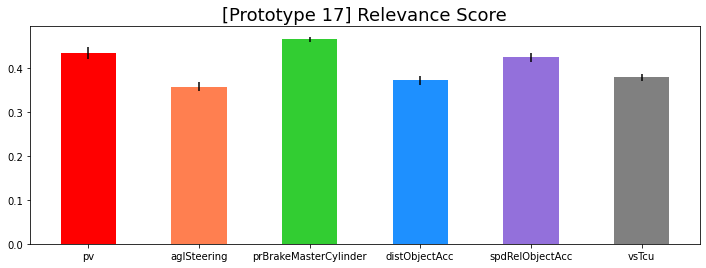

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


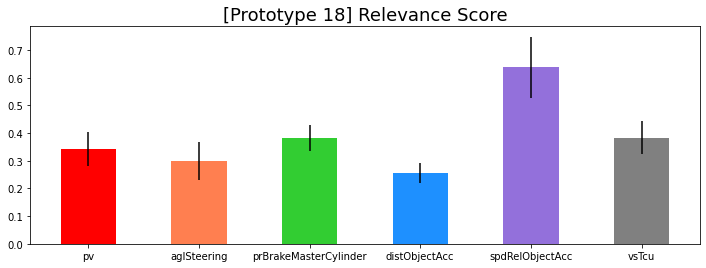

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


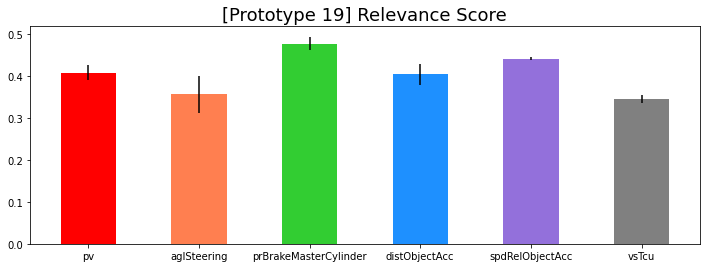

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


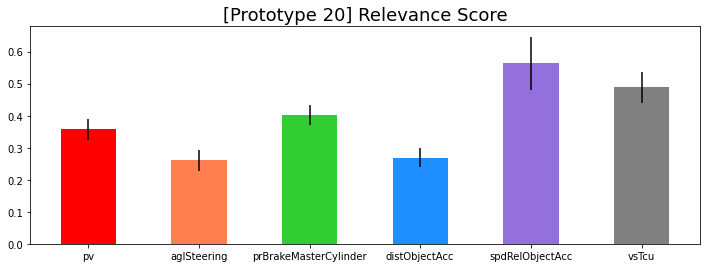

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


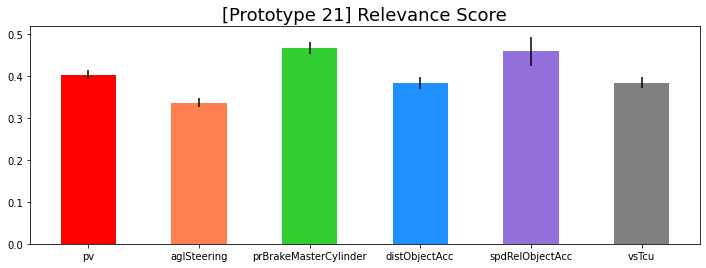

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


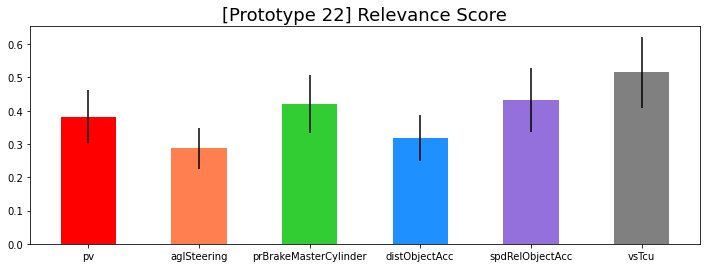

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33it/s]


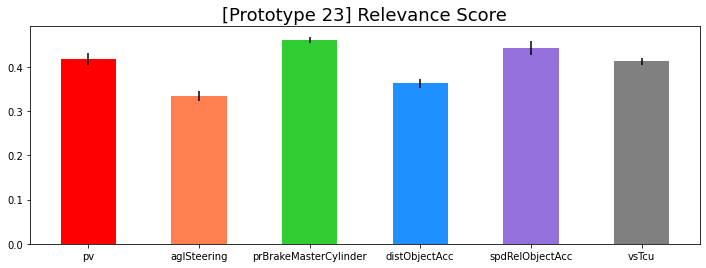

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


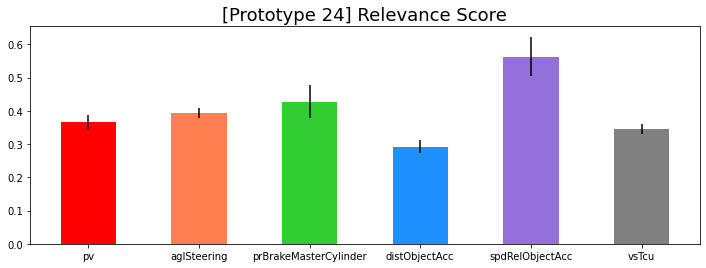

In [119]:
for pg in range(25):
    
    tmp_indices = np.where(proto_class==pg)[0]
    sample_tmp_indices = np.random.choice(tmp_indices, 100, replace=False)
    rel_past_list = []
    rel_forward_list = []

    for i in trange(100):
        tf1.reset_default_graph()
        idx = sample_tmp_indices[i]

        output_time_steps=10
        pos_enc_past = tf.tile(tf.expand_dims(pos_encoder(np.arange(10), 40), axis=0), [1, 1, 1])
        pos_enc_fwd = tf.tile(tf.expand_dims(pos_encoder(np.arange(100)), axis=0), [1, 1, 1])

        # Data Sampling
        x_past = scaled_data_past[idx:idx+1]
        x_forward = scaled_data_map[idx:idx+1]
        y = scaled_data_pred[idx:idx+1]

        get_act_model(model, x_past, x_forward, pos_enc_past, pos_enc_fwd)
        lrp = RelevancePropagation()
        sample_rel_input, sample_rel_forward = lrp.run_lrp_input()
        rel_past_list.append(sample_rel_input)
        rel_forward_list.append(sample_rel_forward)

        del lrp
        tf1.reset_default_graph()
    
    
    rel_past_np = np.vstack(rel_past_list)
    rel_forward_np = np.vstack(rel_forward_list)
    
    rel_past_dict[pg] = rel_past_np
    rel_forward_dict[pg] = rel_forward_np
    
    rel_past_sum = np.sum(rel_past_np, axis=1)
    rel_past_sum = rel_past_sum/np.linalg.norm(rel_past_sum, axis=1)[:,np.newaxis]

#     tar_past_sum = tf.reduce_sum(rel_input[0], axis=0),
#     tar_past_sum = (tar_past_sum/np.linalg.norm(tar_past_sum, axis=1)[:,np.newaxis])[0]
    
    tmp_mean = np.mean(rel_past_sum, axis=0)
    tmp_std = np.std(rel_past_sum, axis=0)
    
    plt.figure(figsize=(12,4))
    plt.title('[Prototype %s] Relevance Score'%format(pg), fontsize=18)
    plt.bar(input_vars, tmp_mean, yerr=tmp_std, color=c_list, width=0.5)
    plt.show()
    
    rel_past_avg_list.append(tmp_mean)
    rel_past_std_list.append(tmp_std)
    

In [159]:
import pickle

with open('./relevance_past_dict.pickle', 'wb') as f:
    pickle.dump(rel_past_dict, f)
    
with open('./relevance_forward_dict.pickle', 'wb') as f:
    pickle.dump(rel_forward_dict, f)
    
with open('./relevance_past_avg.pickle', 'wb') as f:
    pickle.dump(rel_past_avg_list, f)

with open('./relevance_past_std.pickle', 'wb') as f:
    pickle.dump(rel_past_std_list, f)


# with open('./relevance_past_dict.pickle', 'rb') as f:
#     dic = pickle.load(f)

In [157]:
with open('./relevance_past_dict.pickle', 'rb') as f:
    dic = pickle.load(f)

In [158]:
dic

{0: array([[[0.    , 0.    , 0.    , 0.0001, 0.0001, 0.    ],
         [0.0002, 0.0001, 0.0002, 0.0002, 0.0003, 0.0002],
         [0.0005, 0.0004, 0.0005, 0.0005, 0.0006, 0.0005],
         ...,
         [0.001 , 0.001 , 0.0011, 0.0009, 0.0008, 0.0009],
         [0.0005, 0.0005, 0.0005, 0.0004, 0.0003, 0.0004],
         [0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001]],
 
        [[0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
         [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
         [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
         ...,
         [0.0002, 0.0001, 0.0002, 0.0001, 0.0001, 0.0001],
         [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
         [0.    , 0.    , 0.    , 0.    , 0.    , 0.    ]],
 
        [[0.0001, 0.    , 0.0001, 0.0001, 0.0001, 0.0001],
         [0.0002, 0.0001, 0.0002, 0.0002, 0.0003, 0.0002],
         [0.0005, 0.0004, 0.0005, 0.0004, 0.0007, 0.0005],
         ...,
         [0.001 , 0.0012, 0.0013, 0.0009, 0.001 , 0.0009],
     

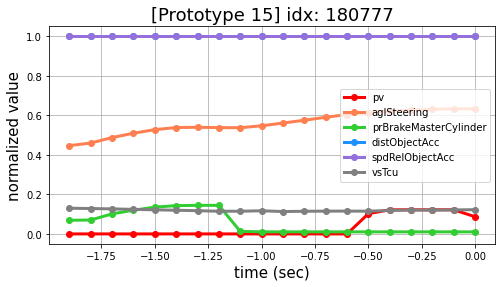

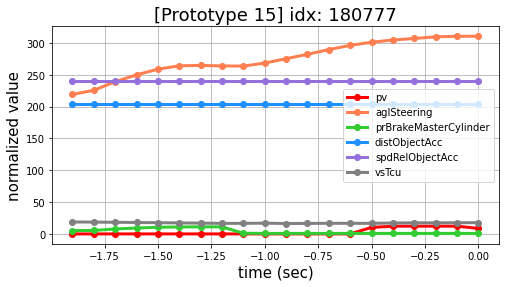

In [1251]:
proto_group = 15 #원하는 그룹 번호

# plt.figure(figsize=(12,4))
plt.figure(figsize=(8,4))
x_proto = scaled_data_past[proto_indices[proto_group]]
for i in range(6):
    plt.plot(x1, x_proto[:,i], '-o',c=c_list[i], linewidth=3)
#     plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])

plt.title('[Prototype %s] idx: %s'%(proto_group, proto_indices[proto_group]), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()

plt.figure(figsize=(8,4))
x_proto = data_past[proto_indices[proto_group]]
for i in range(6):
    plt.plot(x1, x_proto[:,i], '-o',c=c_list[i], linewidth=3)
#     plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])

plt.title('[Prototype %s] idx: %s'%(proto_group, proto_indices[proto_group]), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()

In [1252]:
tmp_indices = np.where(proto_class==proto_group)[0]


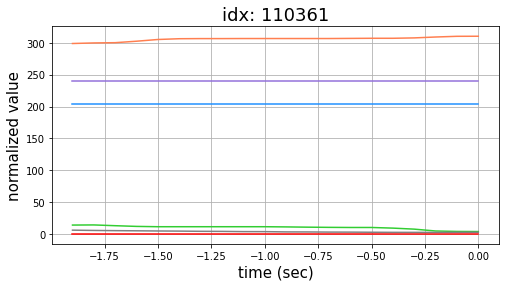

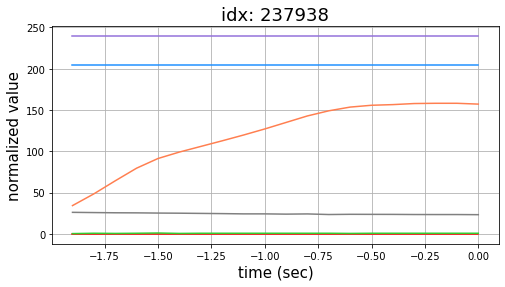

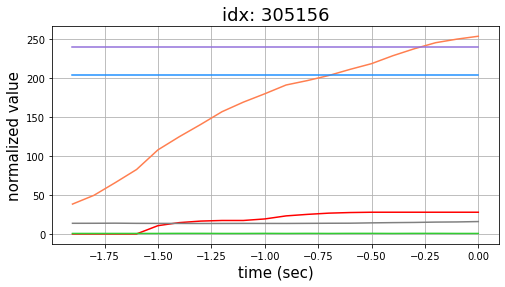

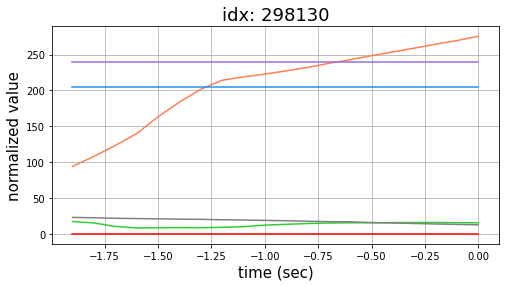

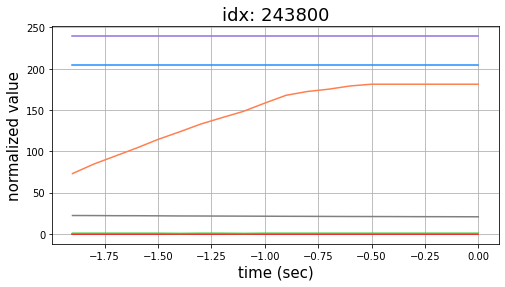

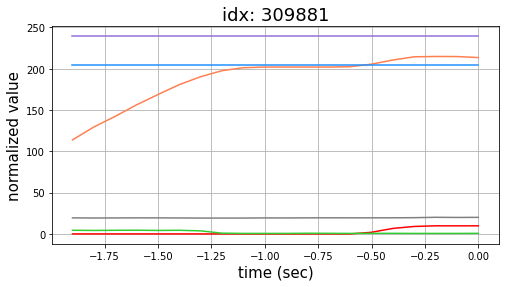

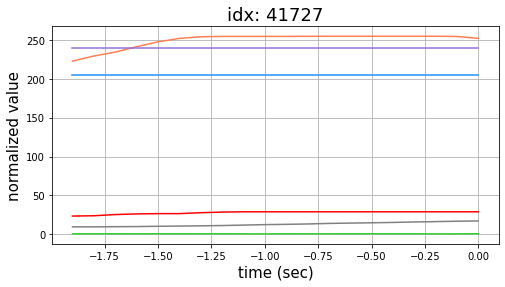

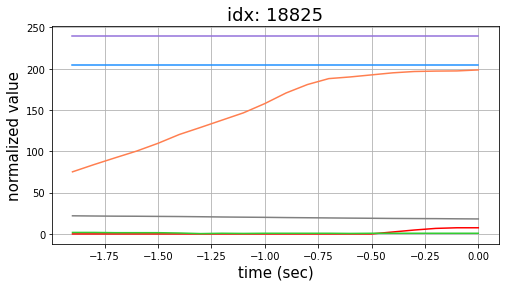

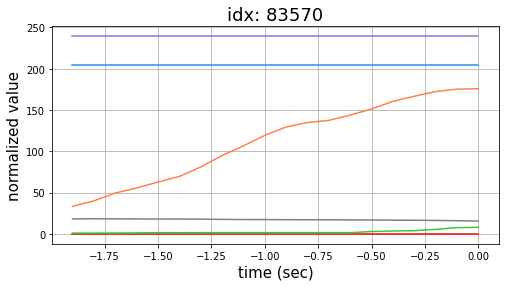

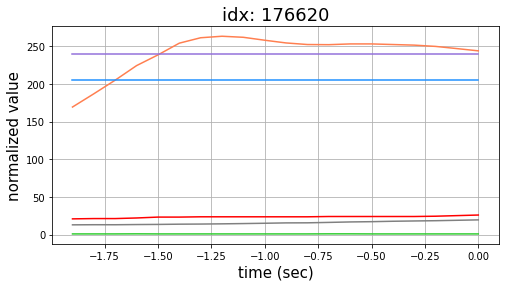

In [1253]:
for idx in np.random.choice(tmp_indices, 10, replace=False):
    
    plt.figure(figsize=(8,4))
    plt.title('idx: %s'%format(idx), fontsize=18)
    x_past = data_past[idx]
    for i in range(6):
        plt.plot(x1, x_past[:,i], '-',c=c_list[i])
    plt.xlabel('time (sec)', fontsize=15)
    plt.ylabel('normalized value', fontsize=15)
#     plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
#                , loc='best')
    plt.grid()

### 실행 ㄱㄱ

## LRP test

In [359]:
cmap_list = ['Reds', 'Oranges', 'Greens', 'Blues','Purples', 'Greys']
c_list = ['r' ,'coral', 'limegreen', 'dodgerblue', 'mediumpurple', 'gray']
input_vars = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']a

In [ ]:
with open('./relevance_past_dict.pickle', 'rb') as f:
    rel_past_dict = pickle.load(f)
    
with open('./relevance_forward_dict.pickle', 'rb') as f:
    rel_forward_dict = pickle.load(f)
    
with open('./relevance_past_avg.pickle', 'rb') as f:
    rel_past_avg_list = pickle.load(f)
    
with open('./relevance_past_std.pickle', 'rb') as f:
    rel_past_std_list = pickle.load(f)


In [185]:
total_rel_mean = np.mean(np.vstack(rel_past_avg_list), axis=0)
total_rel_std = np.mean(np.vstack(rel_past_std_list), axis=0)

---

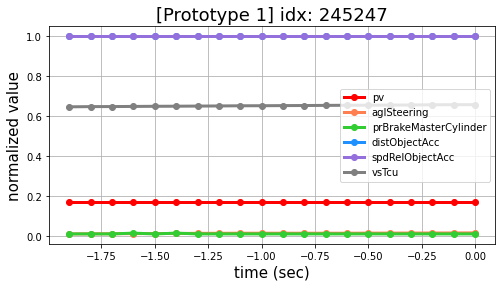

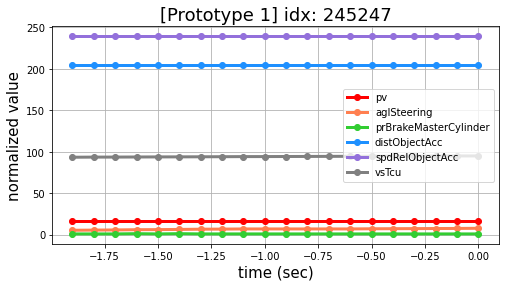

In [1214]:
proto_group = 1 #원하는 그룹 번호

# plt.figure(figsize=(12,4))
plt.figure(figsize=(8,4))
x_proto = scaled_data_past[proto_indices[proto_group]]
for i in range(6):
    plt.plot(x1, x_proto[:,i], '-o',c=c_list[i], linewidth=3)
#     plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])

plt.title('[Prototype %s] idx: %s'%(proto_group, proto_indices[proto_group]), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()

plt.figure(figsize=(8,4))
x_proto = data_past[proto_indices[proto_group]]
for i in range(6):
    plt.plot(x1, x_proto[:,i], '-o',c=c_list[i], linewidth=3)
#     plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])

plt.title('[Prototype %s] idx: %s'%(proto_group, proto_indices[proto_group]), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()

In [1185]:
# Parameters
# Sample index
# idx = 246289
# idx = np.random.choice(300000, 1)[0]

 
tmp_indices = np.where(proto_class==proto_group)[0]
idx = np.random.choice(tmp_indices, 1)[0]
# idx = 5446

output_time_steps=10
pos_enc_past = tf.tile(tf.expand_dims(pos_encoder(np.arange(10), 40), axis=0), [1, 1, 1])
pos_enc_fwd = tf.tile(tf.expand_dims(pos_encoder(np.arange(100)), axis=0), [1, 1, 1])

# Data Sampling
x_past = scaled_data_past[idx:idx+1]
x_forward = scaled_data_map[idx:idx+1]
y = scaled_data_pred[idx:idx+1]
print(f'Past data shape: {x_past.shape}')
print(f'Forward data shape: {x_forward.shape}')
print(f'Prediction target data shape: {y.shape}')

Past data shape: (1, 20, 6)
Forward data shape: (1, 100, 4)
Prediction target data shape: (1, 10, 1)


In [1186]:
output = model(x_past, x_forward, pos_enc_past, pos_enc_fwd)

mse
[[ 0.5432]
 [ 0.5772]
 [ 0.0361]
 [ 0.7006]
 [ 7.9648]
 [13.4105]
 [25.9937]
 [29.5052]
 [13.8203]
 [ 6.428 ]]
mean =  9.897957
mae
[[0.737 ]
 [0.7597]
 [0.1899]
 [0.837 ]
 [2.8222]
 [3.662 ]
 [5.0984]
 [5.4319]
 [3.7176]
 [2.5354]]
mean =  2.5791075


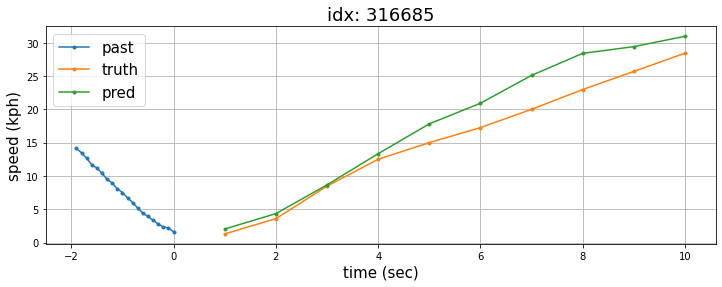

In [1187]:
# Error evaluation
error = pred_max * (y-output)
mse = np.mean(np.square(error), axis=0)
mae = np.mean(np.abs(error), axis=0)

np.set_printoptions(precision=4, suppress=True)
print("mse")
print(mse)
print("mean = ", np.mean(mse))
print("mae")
print(mae)
print("mean = ", np.mean(mae))

# Results Visualize
x1 = np.arange(1, 21)*0.1 - 2
x2 = np.arange(1, 11)
plt.figure(figsize=(12,4))
plt.title('idx: %s'%format(idx), fontsize=18)
plt.plot(x1, (x_past*past_max)[0, :, -1], '.-', label='past')
plt.plot(x2, y[0]*pred_max[0], '.-', label='truth')
plt.plot(x2, output[0]*pred_max, '.-', label='pred')
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('speed (kph)', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

In [1188]:
model.output_time_steps = 10
tf1.reset_default_graph()
get_act_model(model, x_past, x_forward, pos_enc_past, pos_enc_fwd)

<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
array([[[0.014 ],
        [0.03  ],
        [0.0599],
        [0.0924],
        [0.1234],
        [0.1448],
        [0.1738],
        [0.1967],
        [0.2037],
        [0.2145]]], dtype=float32)>

In [1189]:
lrp = RelevancePropagation()
rel_input, rel_forward = lrp.run_lrp_input()

In [1190]:
proto_group = proto_class[idx]
tmp_indices = np.where(proto_class==proto_group)[0]

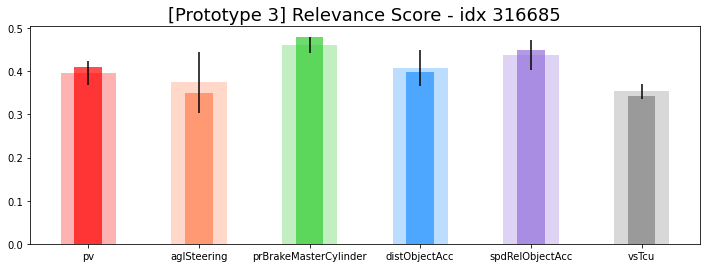

In [1191]:
pg = proto_group

tmp_mean = rel_past_avg_list[pg]
tmp_std = rel_past_std_list[pg]

tar_past_sum = tf.reduce_sum(rel_input[0], axis=0),
tar_past_sum = (tar_past_sum/np.linalg.norm(tar_past_sum, axis=1)[:,np.newaxis])[0]

plt.figure(figsize=(12,4))
plt.title('[Prototype %d] Relevance Score - idx %d'%(pg, idx), fontsize=18)
plt.bar(input_vars, tmp_mean, yerr=tmp_std, color=c_list, width=0.5, alpha=0.3)
plt.bar(input_vars, tar_past_sum, color=c_list, width=0.25, alpha=0.7)
plt.show()

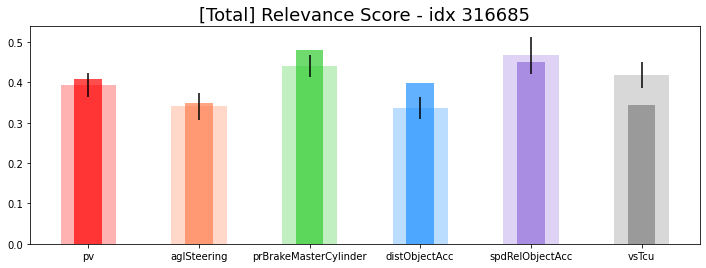

In [1192]:
plt.figure(figsize=(12,4))
plt.title('[Total] Relevance Score - idx %d'%(idx), fontsize=18)
plt.bar(input_vars, total_rel_mean, yerr=total_rel_std, color=c_list, width=0.5, alpha=0.3)
plt.bar(input_vars, tar_past_sum, color=c_list, width=0.25, alpha=0.7)
plt.show()

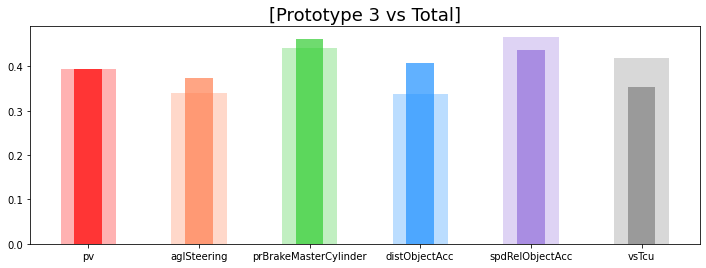

In [1193]:
plt.figure(figsize=(12,4))
plt.title('[Prototype %d vs Total]'%(pg), fontsize=18)
plt.bar(input_vars, total_rel_mean, color=c_list, width=0.5, alpha=0.3)
plt.bar(input_vars, tmp_mean, color=c_list, width=0.25, alpha=0.7)
plt.show()

<BarContainer object of 6 artists>

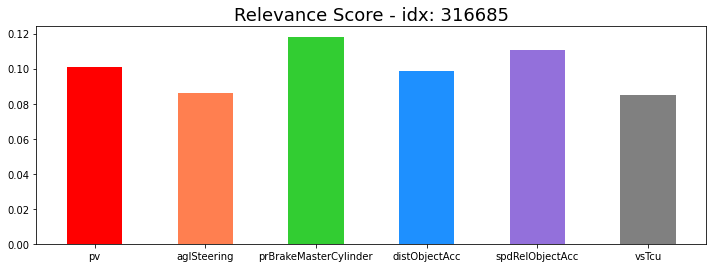

In [1194]:
plt.figure(figsize=(12,4))
plt.title('Relevance Score - idx: %s'%format(idx), fontsize=18)
plt.bar(input_vars, tf.reduce_sum(rel_input[0], axis=0), color=c_list, width=0.5)
# plt.ylim((0,0.2))

In [1195]:
legends = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']


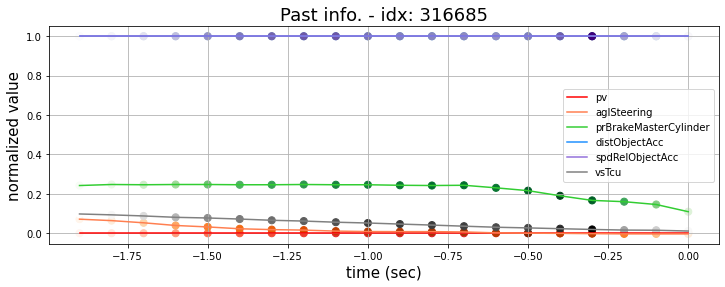

In [1196]:
plt.figure(figsize=(12,4))

# plt.plot(x1, x_past[0], '.-')

for i in range(6):
    plt.plot(x1, x_past[0,:,i], '-',c=c_list[i], label=legends[i])
    plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])
    
plt.title('Past info. - idx: %s'%format(idx), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.grid()
plt.legend(loc='best')

# Attention

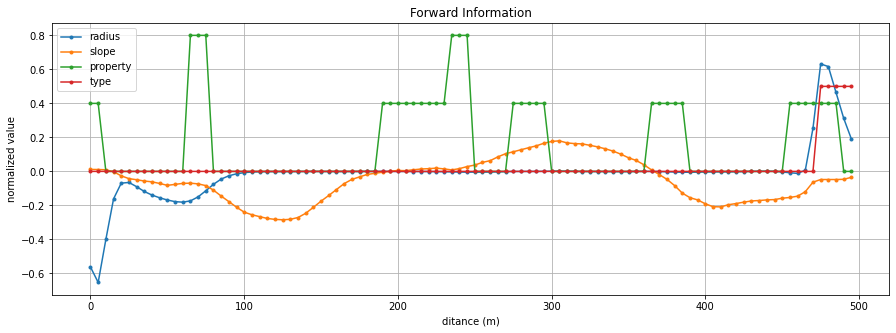

In [1197]:
xf = np.arange(100)*5

plt.figure(figsize=(15,5))
plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('ditance (m)')
plt.ylabel('normalized value')
plt.title('Forward Information')
plt.grid()

In [1198]:
print(x_forward.shape)
print(pos_enc_fwd.shape)
print(output_time_steps)

pos_enc_past = tf.tile(tf.expand_dims(pos_encoder(np.arange(10), 40), axis=0), [1, 1, 1])
pos_enc_fwd = tf.tile(tf.expand_dims(pos_encoder(np.arange(100)), axis=0), [1, 1, 1])

x_past = scaled_data_past[idx:idx+1]
x_forward = scaled_data_map[idx:idx+1]

(1, 100, 4)
(1, 100, 4)
10


In [1199]:
code_past = model.relu(model.dense1(model.flatten(model.enc_past(x_past))))
code_past = tf.tile(tf.expand_dims(code_past, axis=1), [1, output_time_steps, 1])

(1, 10, 36)
(1, 10, 32)
(1, 100, 16)


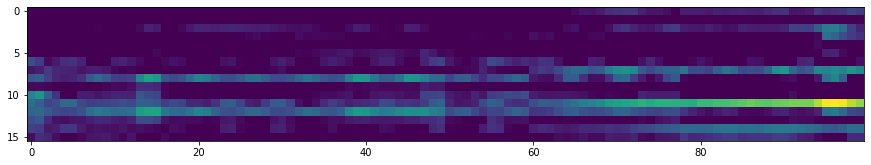

In [1200]:
query = tf.concat([code_past, pos_enc_past], axis=-1)
print(query.shape)

query = model.relu(model.dense2(query))
print(query.shape)

feature = tf.concat([x_forward, pos_enc_fwd], axis=-1)
feature = model.spatial_att.relu(model.spatial_att.dense2(model.spatial_att.relu(model.spatial_att.dense1(feature))))

print(feature.shape)

plt.figure(figsize=(15,5))
plt.imshow(tf.transpose(feature, [0, 2, 1])[0])

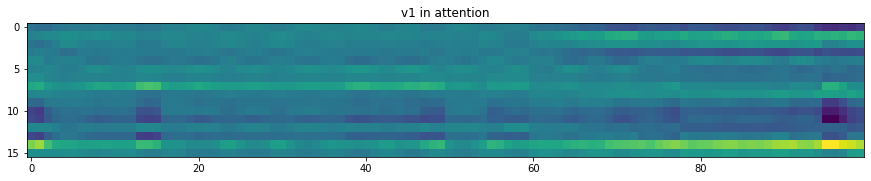

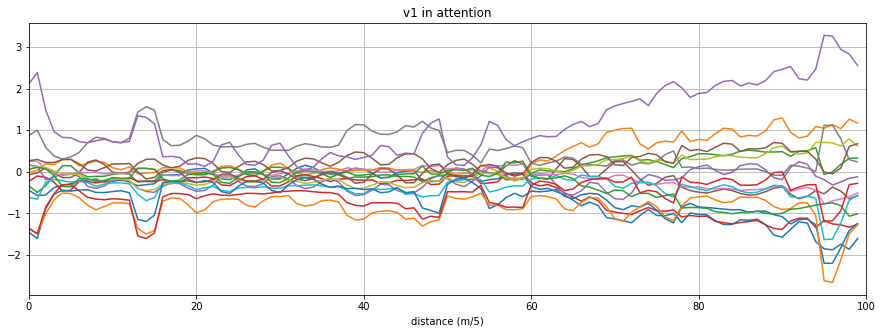

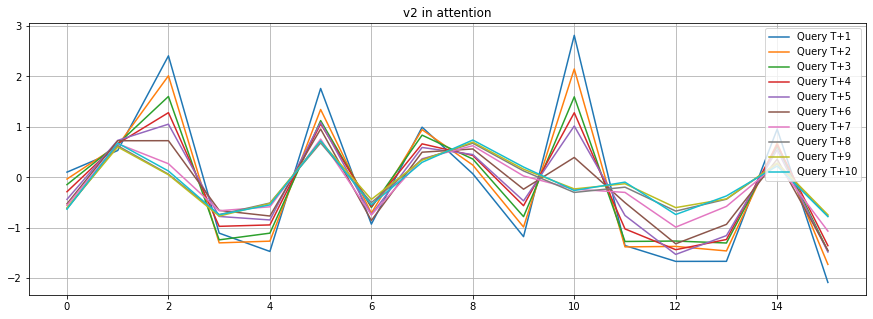

In [1201]:
v1 = model.spatial_att.u_e(feature)
v2 = model.spatial_att.w_e(query)

# visualize v1
plt.figure(figsize=(15,5))
plt.imshow(tf.transpose(v1, [0, 2, 1])[0])
# plt.colorbar()
plt.title('v1 in attention')

plt.figure(figsize=(15,5))
for i in range(v1.shape[-1]):
    plt.plot(v1[0, :, i], label=str(i))
plt.xlim([0, 100])
plt.title('v1 in attention')
plt.xlabel('distance (m/5)')
# plt.legend()
plt.grid()

# visualize v2
plt.figure(figsize=(15,5))
for i in range(v2.shape[1]):
    plt.plot(v2[0, i], label='Query T+'+str(i+1))
plt.title('v2 in attention')
plt.legend()
plt.grid()

In [1202]:
v2 = tf.expand_dims(v2, axis=2)  # shape: [batch, self.output_time_steps, 1, units]
e_t = tf.squeeze(model.spatial_att.v_e(model.spatial_att.tanh(v1 + v2)), axis=-1)  # shape: [batch, self.output_time_steps, feature_length]
alpha_t = model.spatial_att.softmax(e_t)  # shape: [batch, self.output_time_steps, feature_length]

In [1203]:
alpha = model.spatial_att(query, tf.expand_dims(tf.concat([x_forward, pos_enc_fwd],axis=-1), axis=1))

In [1204]:
alpha.shape

TensorShape([1, 10, 100])

Text(0.5, 1.0, 'alpha')

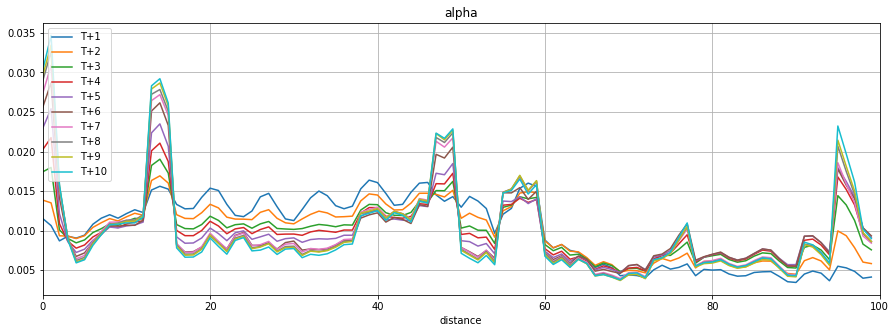

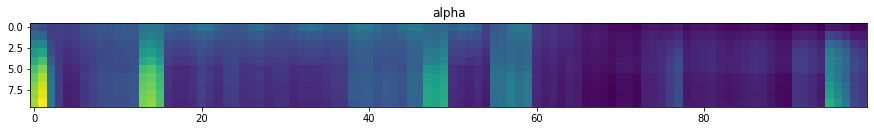

In [1205]:
# visualize
plt.figure(figsize=(15,5))
for i in range(alpha.shape[1]):
    plt.plot(alpha[0, i], label='T+'+str(i+1))
plt.xlim([0, 100])
plt.xlabel('distance')
plt.title('alpha')
plt.legend()
plt.grid()

plt.figure(figsize=(15,5))
plt.imshow(alpha[0])
plt.title('alpha')

Text(0.5, 1.0, 'alpha')

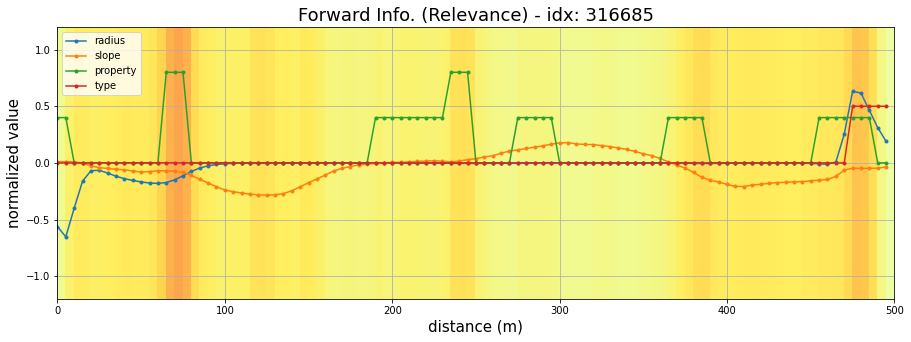

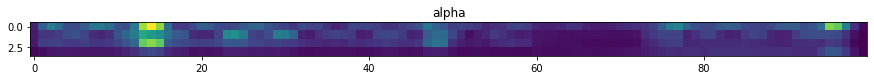

In [1206]:
rel_mean = np.mean(rel_forward[0,:,:], axis=1)

plt.figure(figsize=(15,5))

plt.imshow(rel_mean[np.newaxis,:], cmap="Wistia", aspect='auto', alpha=0.7, extent=[0,500,-1.2,1.2])

plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('distance (m)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.title('Forward Info. (Relevance) - idx: %s'%format(idx), fontsize=18)
plt.grid()

plt.figure(figsize=(15,5))
plt.imshow(np.transpose(rel_forward[0,:,:4]))
plt.title('alpha')

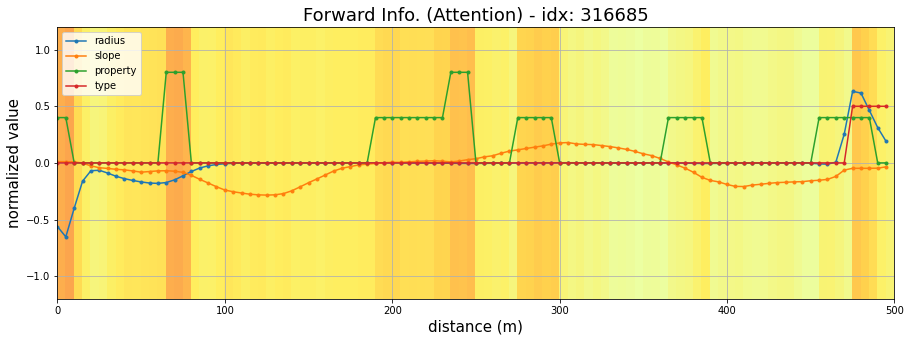

In [1207]:
alpha_mean = np.mean(alpha[0], axis=0)

plt.figure(figsize=(15,5))

plt.imshow(alpha_mean[np.newaxis,:], cmap="Wistia", aspect='auto', alpha=0.7, extent=[0,500,-1.2,1.2])

plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('distance (m)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.title('Forward Info. (Attention) - idx: %s'%format(idx), fontsize=18)
plt.grid()



Text(0.5, 1.0, 'alpha')

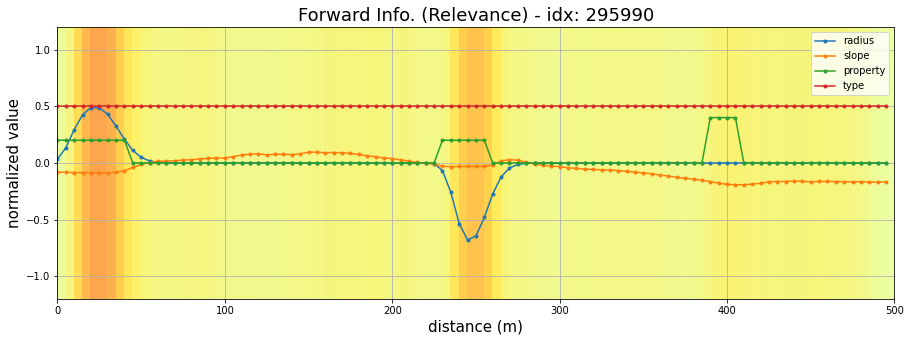

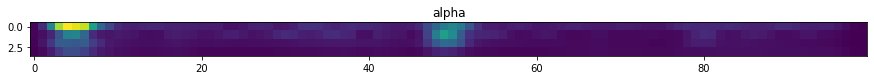

In [1077]:
rel_mean = np.mean(rel_forward[0,:,:], axis=1)

plt.figure(figsize=(15,5))

plt.imshow(rel_mean[np.newaxis,:], cmap="Wistia", aspect='auto', alpha=0.7, extent=[0,500,-1.2,1.2])

plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('distance (m)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.title('Forward Info. (Relevance) - idx: %s'%format(idx), fontsize=18)
plt.grid()

plt.figure(figsize=(15,5))
plt.imshow(np.transpose(rel_forward[0,:,:4]))
plt.title('alpha')

In [1053]:
rel_forward.shape

(1, 100, 8)

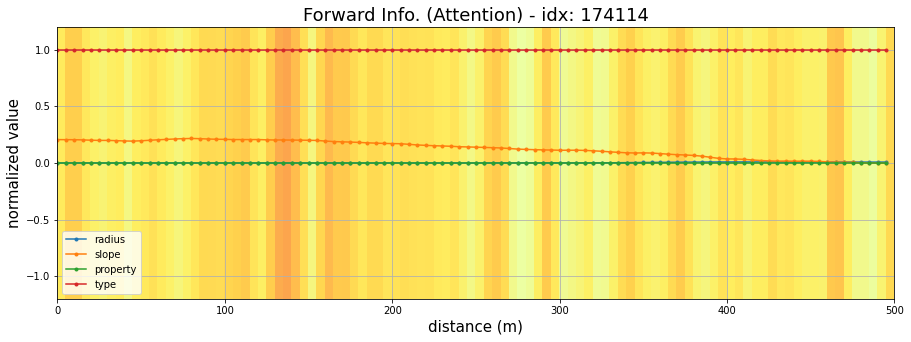

In [630]:
alpha_mean = np.mean(alpha[0], axis=0)

plt.figure(figsize=(15,5))

plt.imshow(alpha_mean[np.newaxis,:], cmap="Wistia", aspect='auto', alpha=0.7, extent=[0,500,-1.2,1.2])

plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('distance (m)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.title('Forward Info. (Attention) - idx: %s'%format(idx), fontsize=18)
plt.grid()



# Latent code_past extraction

In [558]:
scaled_data_past.shape

(351265, 20, 6)

In [559]:
bs = 300 # batch size
code_list = []

for i in range(351265//bs):
    x_past = scaled_data_past[i*bs:(i+1)*bs]
    code_past = model.relu(model.dense1(model.flatten(model.enc_past(x_past))))
    code_list.append(code_past)
    
code_past_all = np.vstack(code_list)
print(code_past_all.shape)


KeyboardInterrupt: 

## Prototype Selection

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

import sys

def check_submodularity(K, n):
    K2 = K.copy()
    scale = n**3 + 2*(n**2) - 2*n - 3
    cond1 = np.all(np.diag(K2) == 1)
    cond2 = np.all( np.sum(K2-np.eye(n), axis=1) < 1 )
    cond3 = np.all( (K2-np.eye(n)) < 1/scale )
    return cond1, cond2, cond3

def greedy_protos(K, candidate_indices, m, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    # colsum = np.array(K.sum(0)).ravel() # same as rowsum
    if is_K_sparse:
        colsum = 2*np.array(K.sum(0)).ravel() / n
    else:
        colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
#     value = np.array([])
    f_list = []
    cond_list = []
    nsk = 0
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        lenS = len(selected)
        if lenS > 0:
            temp = K[selected, :][:, candidates]
            if is_K_sparse:
                # s2array = temp.sum(0) *2
                s2array = temp.sum(0) * 2 + K.diagonal()[candidates]

            else:
                s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]

            s2array = s2array/(lenS + 1)

            s3array = s1array - s2array

        else:
            if is_K_sparse:
                s3array = s1array - (np.abs(K.diagonal()[candidates]))
            else:
                s3array = s1array - (np.abs(np.diagonal(K)[candidates]))
        
        max_idx = np.argmax(s3array)
        if lenS > 0:
            sk = np.sum(K[selected, :][:, selected])
            f = s3array[max_idx]/(lenS+1) - nsk/(lenS*(lenS+1)) + (1/(lenS**2)-1/((lenS+1)**2))*sk
            f_list.append(f)
        else:
            f_list.append(s3array[max_idx])
        
        argmax = candidates[max_idx]
        # print("max %f" %np.max(s1array))

        selected = np.append(selected, argmax)
        
        '''nsk: (2/n)*\sum{k([n],S)}'''
        nsk += s1array[max_idx]
        
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        
        '''validity check'''
        cond1, cond2, cond3 = check_submodularity(KK, len(selected))
#         print("%s, %s, %s"%(cond1, cond2, cond3))
        cond_list.append([cond1, cond2, cond3])
        
        if is_K_sparse:
            KK = KK.todense()

#         inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected], f_list, cond_list

In [ ]:
indices = np.random.choice(351000, 30000, replace=False)

In [ ]:
normalized_code = code_past_all[indices] / np.linalg.norm(code_past_all[indices], axis=1)[:, np.newaxis]

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

feature_kernel = np.power(linear_kernel(normalized_code), 30)

In [ ]:
n_samples = len(normalized_code)
n_cluster = 30
kernel_matrix = feature_kernel

In [292]:
%%time
selected, f_list, _ = greedy_protos(kernel_matrix, np.arange(n_samples), n_cluster)
print(selected)

[ 4407 19752  5746  1426 14842 21951  8122 26764 12818 26280 11688  2432
 26347  2241 19284 23717 29220  7369 25396 15278 14736  6311  8295    58
 29988 28142  1252 18568 22406  8601]
CPU times: user 531 ms, sys: 15.5 ms, total: 547 ms
Wall time: 545 ms


In [657]:
indices[selected]

array([206719, 245247, 242974,  19816, 183602, 258237, 155661,  16503,
       151977, 182308, 147410, 339701,  80710, 100287, 308485, 180777,
       306122, 123046, 219143, 328217, 319560,  86747, 257775, 348141,
        48825,  86695, 281289, 125678, 342719, 172892])

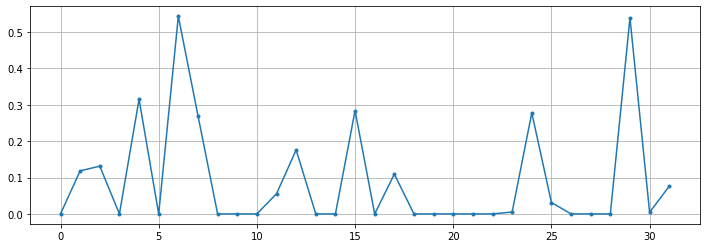

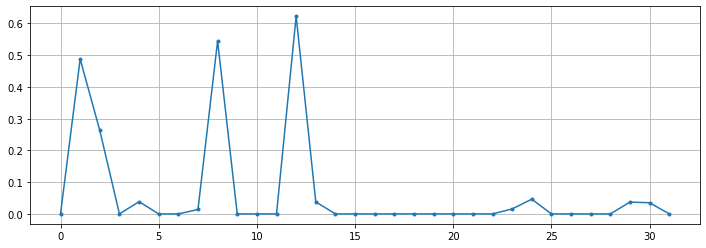

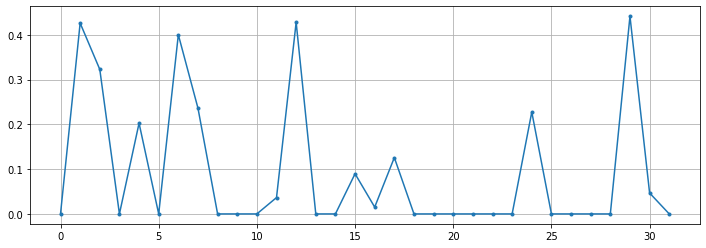

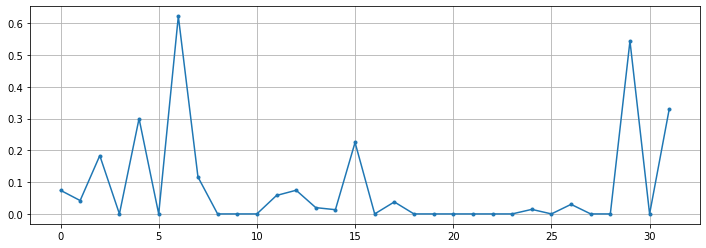

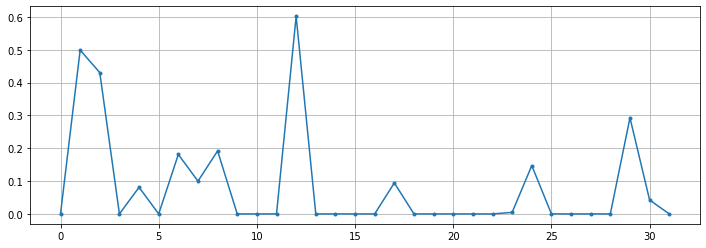

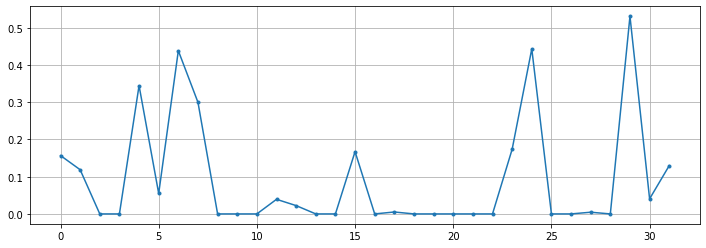

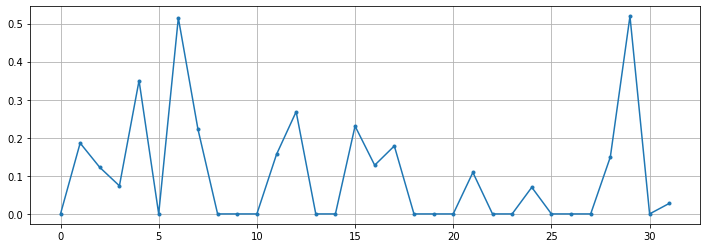

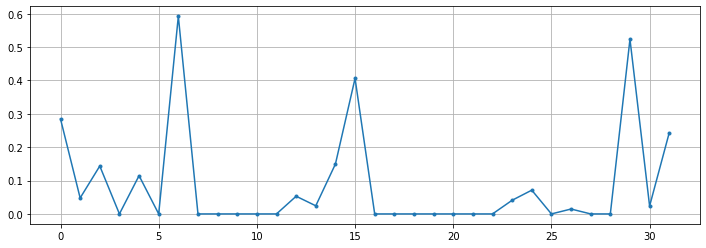

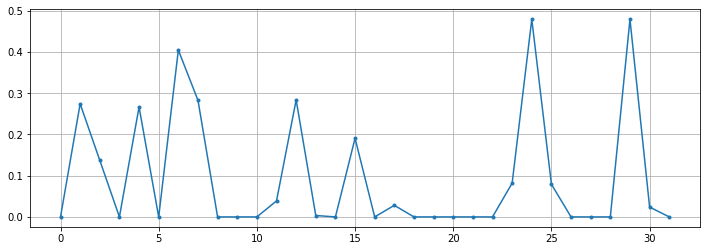

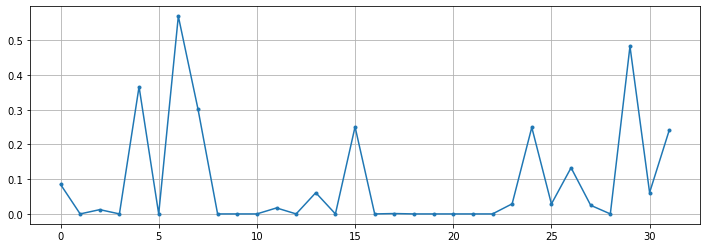

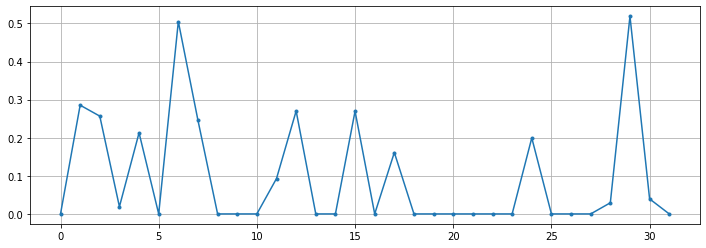

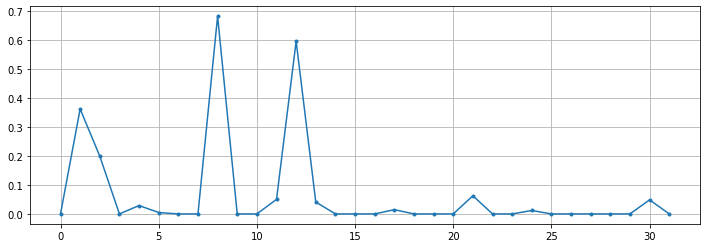

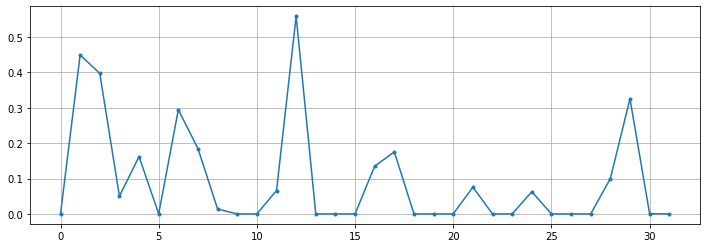

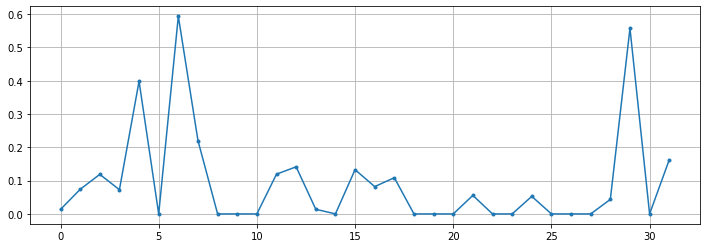

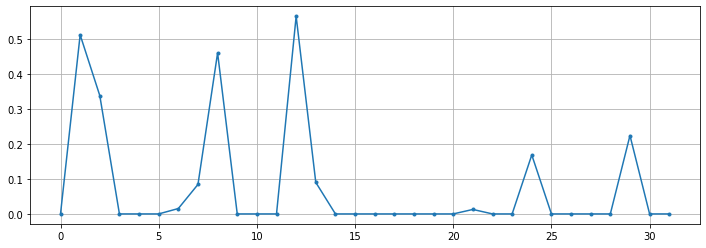

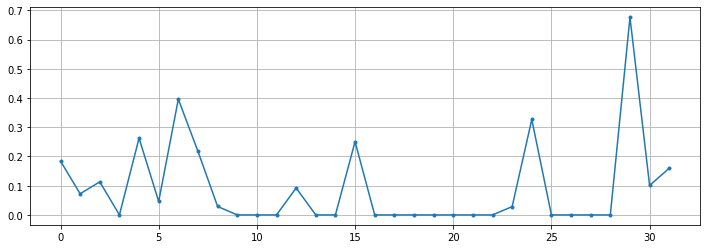

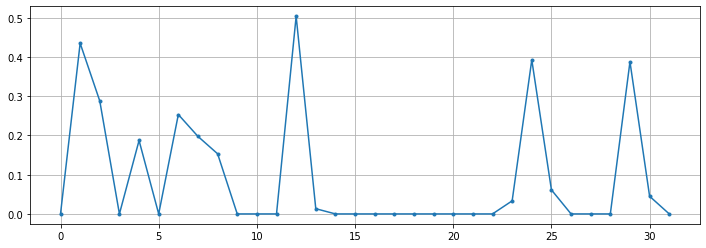

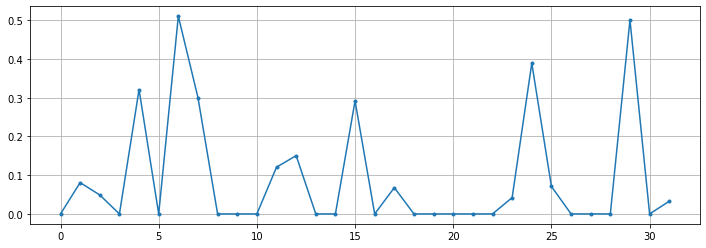

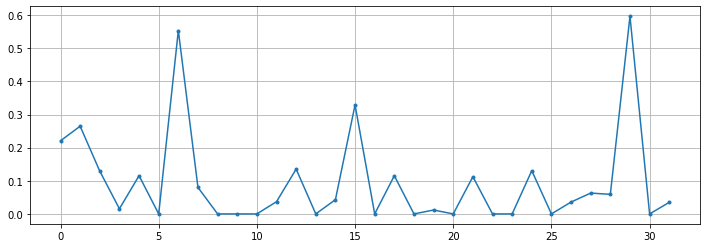

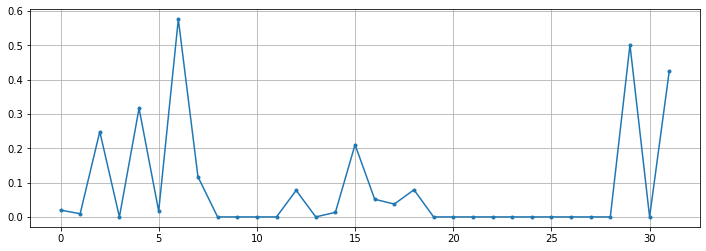

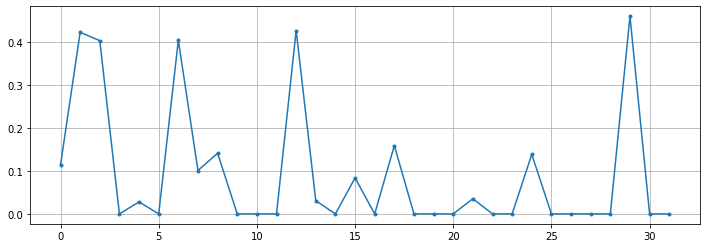

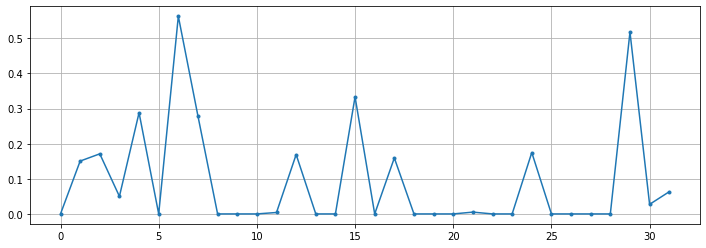

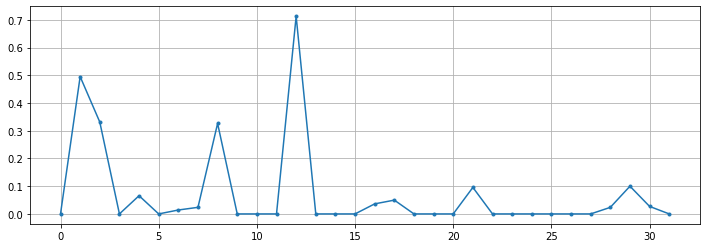

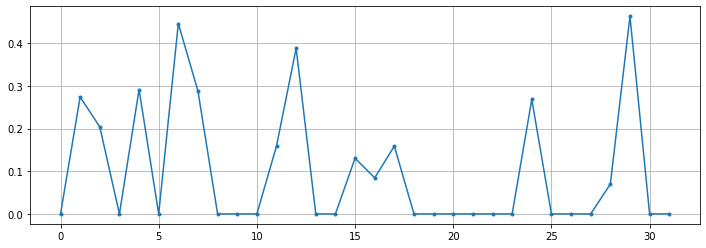

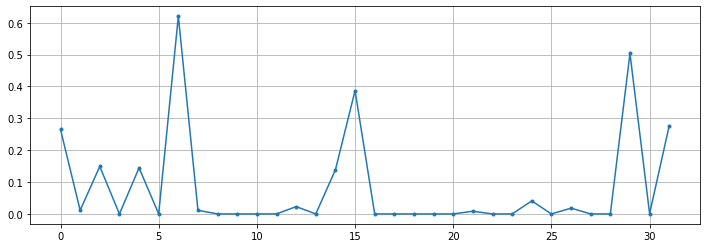

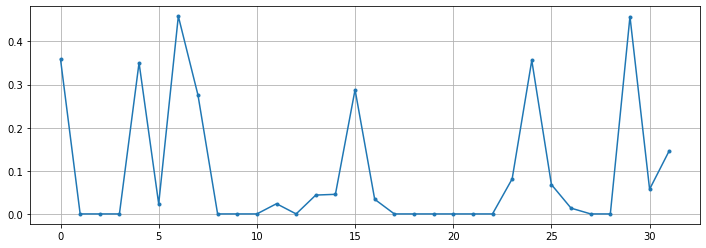

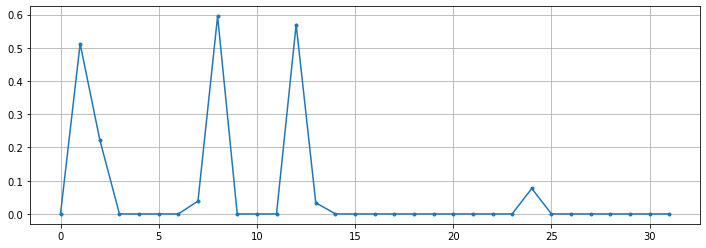

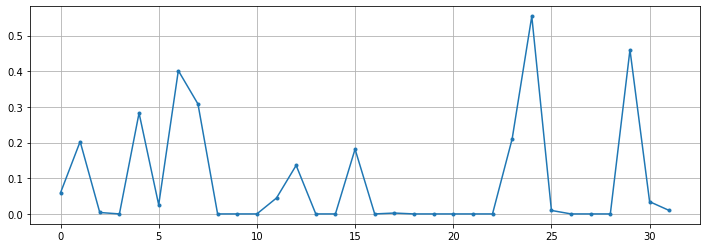

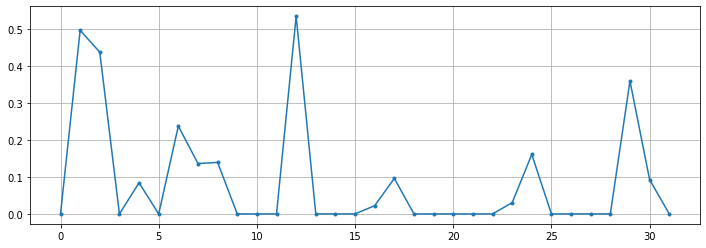

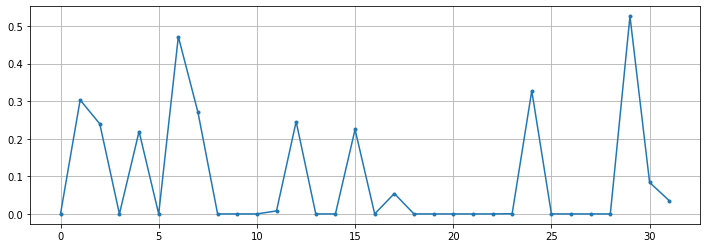

In [293]:
for i in selected:
    plt.figure(figsize=(12,4))
    plt.plot(normalized_code[i], '.-')
    plt.grid()
    plt.show()

In [279]:
np.cumsum(f_list)

array([-0.7506, -0.2971, -0.147 , -0.08  , -0.0419, -0.016 ,  0.0005,
        0.0123,  0.0207,  0.0275,  0.0335,  0.0348,  0.0363,  0.0376,
        0.0387,  0.0402,  0.0413,  0.042 ,  0.043 ,  0.0437])

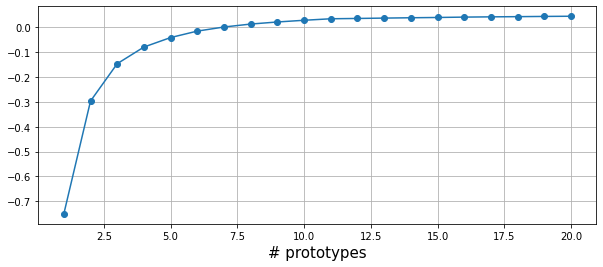

In [280]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(f_list))+1,np.cumsum(f_list), '-o')
plt.xlabel('# prototypes', fontsize=15)
plt.grid()

In [308]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(code_past_all[indices])

In [344]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.001s...
[t-SNE] Computed neighbors for 30000 samples in 20.225s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

In [364]:
n_use = 30
proto_class = np.argmax(kernel_matrix[:,selected[:n_use]], axis=1)

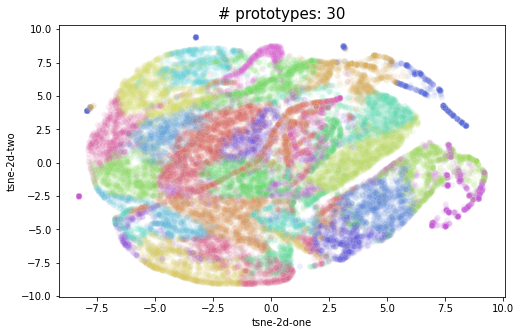

In [365]:
df_subset = pd.DataFrame(columns = ['tsne-2d-one', 'tsne-2d-two']) 
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['proto'] = proto_class

plt.figure(figsize=(8,5))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two"
# )
plt.title('# prototypes: %d'%(n_use), fontsize=15)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="proto",
    palette=sns.color_palette("hls", n_use),
    data=df_subset,
#     legend="full",
    alpha=0.1
)
plt.legend([],[],frameon=False)
plt.show()

In [366]:
# plt.hist2d(tsne_results[:,0], tsne_results[:,1], 
#            bins=30, cmap=plt.cm.BuPu);

In [368]:
n_use = 25
proto_class = np.argmax(kernel_matrix[:,selected[:n_use]], axis=1)

In [385]:
print(selected[:n_use])

[ 4407 19752  5746  1426 14842 21951  8122 26764 12818 26280 11688  2432
 26347  2241 19284 23717 29220  7369 25396 15278 14736  6311  8295    58
 29988]


In [381]:
''' prototype 중 하나 선택 '''
proto_tar = 15

tmp_indices = np.where(proto_class==proto_tar)[0]

In [382]:

np.random.choice(tmp_indices, 10, replace=False)

array([ 7142,   670,  6381,  5563, 19610, 27126, 29444, 24861,  9693,
       20495])

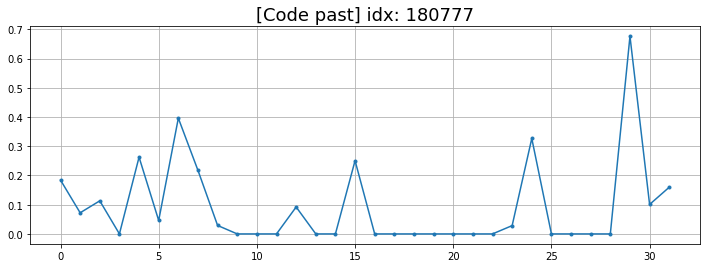

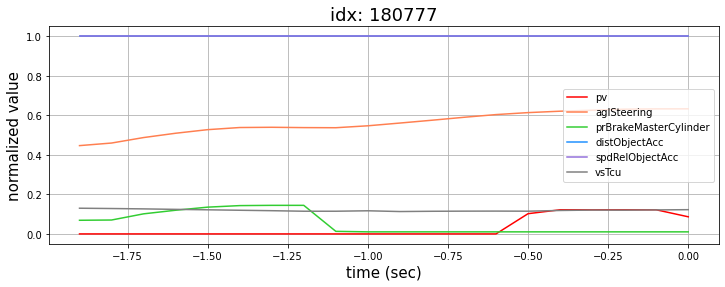

In [383]:
''' prototype code_past 출력 및 input 관찰 '''

sampled_idx = selected[proto_tar]
real_idx = indices[sampled_idx]

plt.figure(figsize=(12,4))
plt.title('[Code past] idx: %s'%format(real_idx), fontsize=18)
plt.plot(normalized_code[sampled_idx], '.-')
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
x_past = scaled_data_past[real_idx]
for i in range(6):
    plt.plot(x1, x_past[:,i], '-',c=c_list[i])
#     plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])

plt.title('idx: %s'%format(real_idx), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()

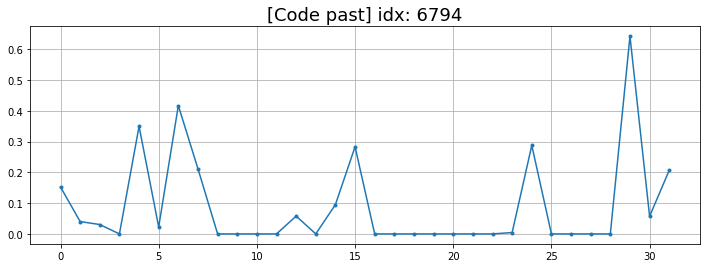

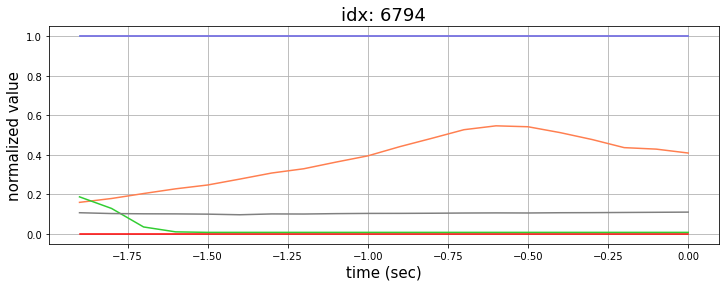

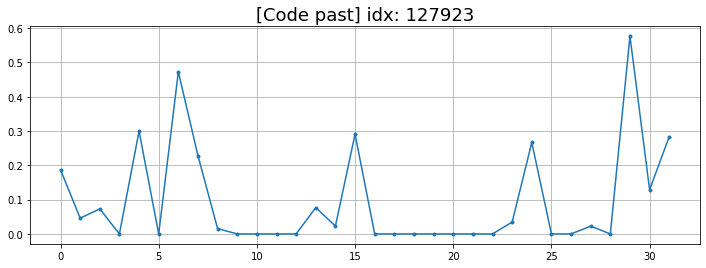

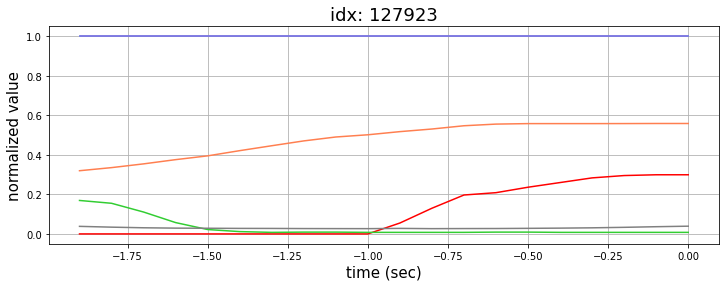

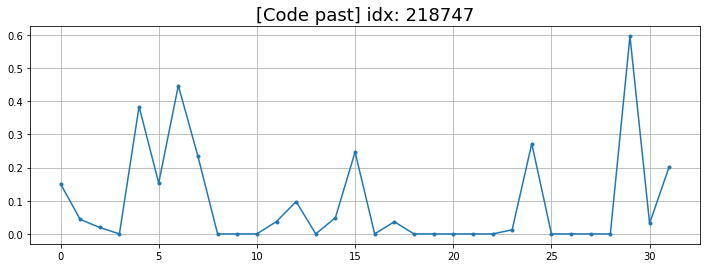

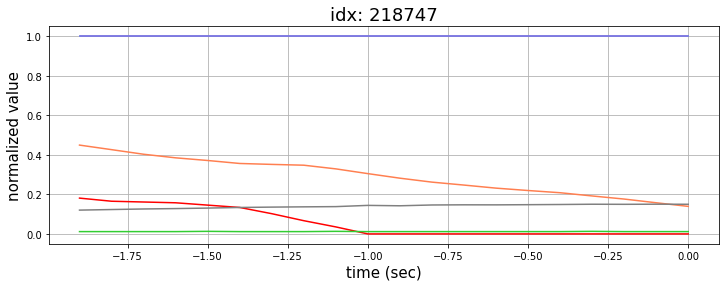

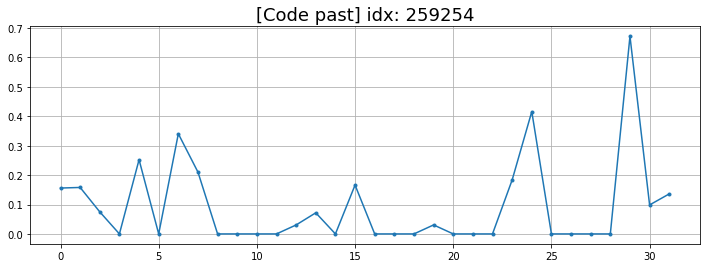

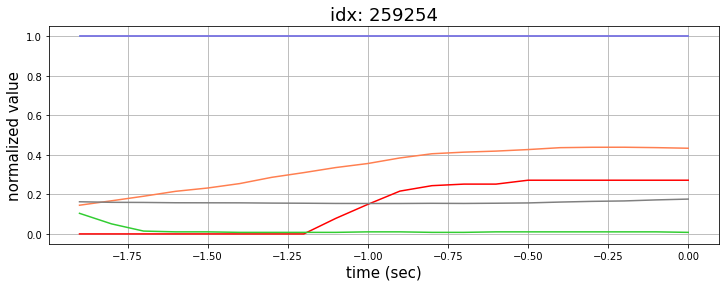

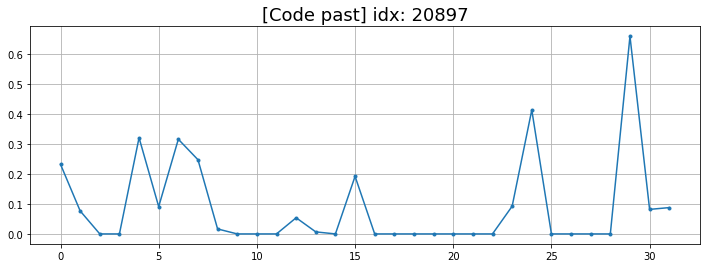

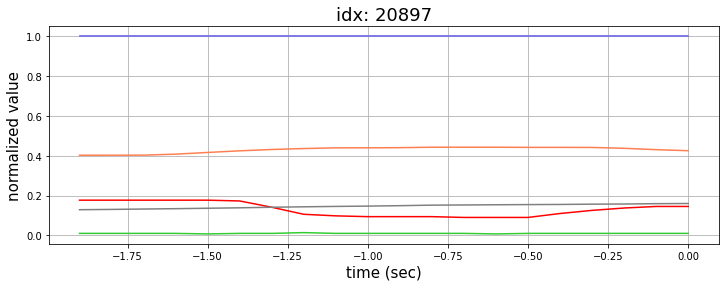

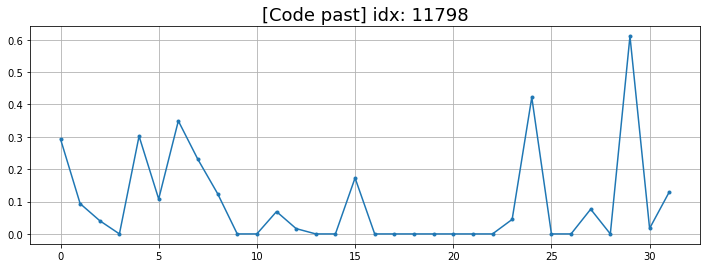

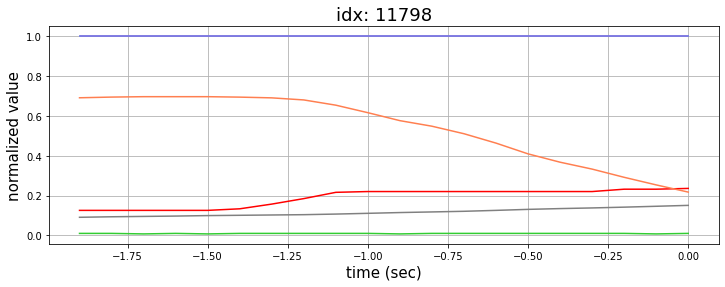

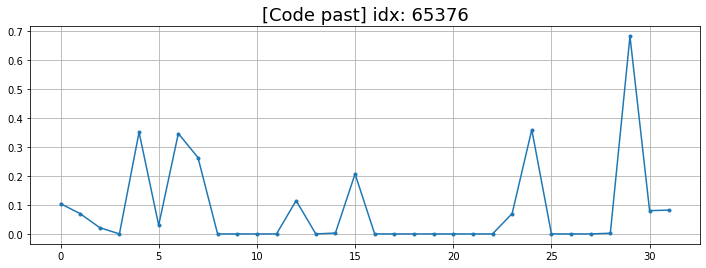

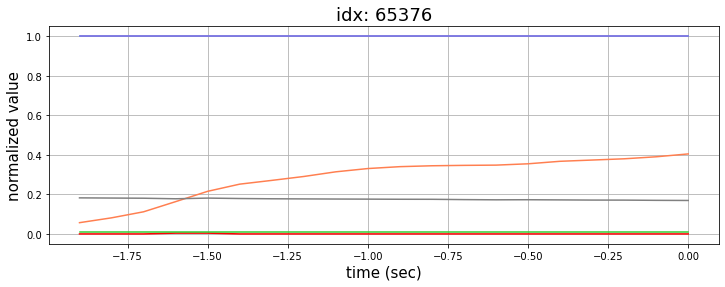

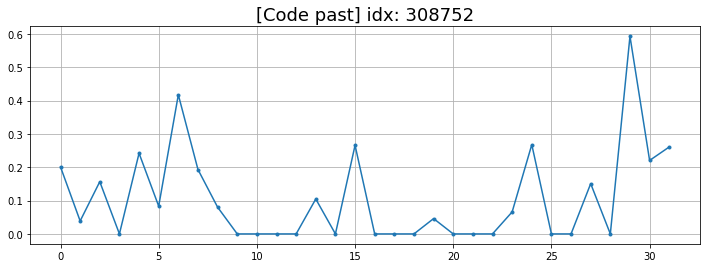

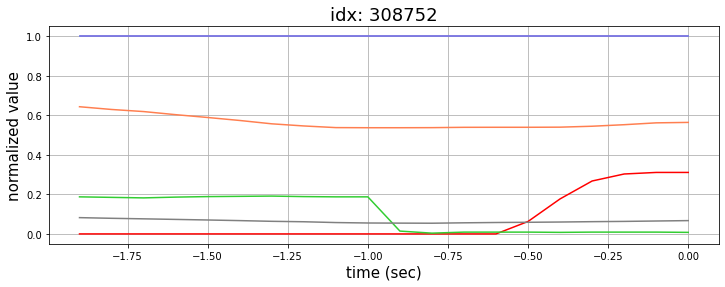

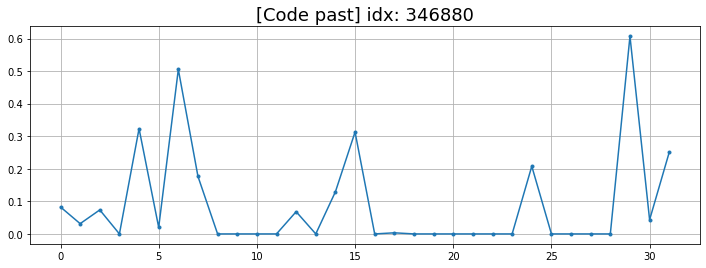

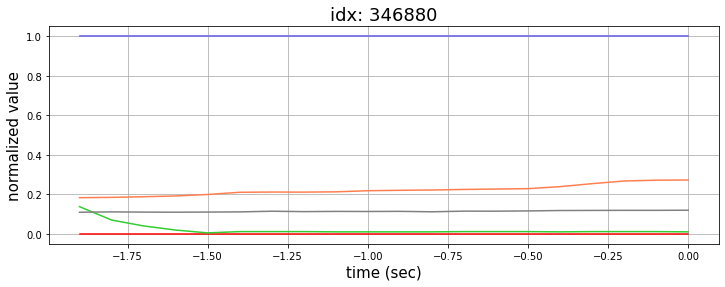

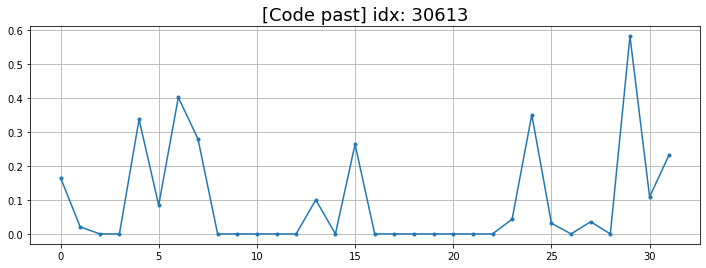

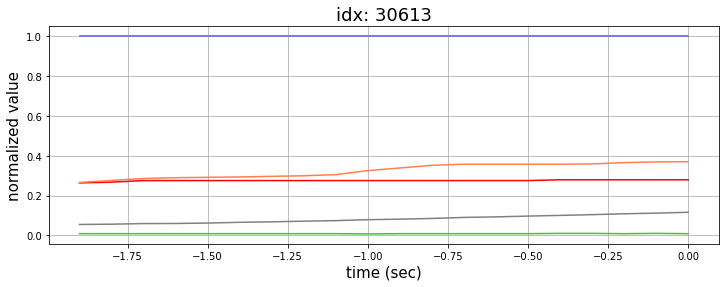

In [384]:
''' 해당 prototype에 속하는 예시 샘플 출력 및 input 관찰 '''

for idx in np.random.choice(tmp_indices, 10, replace=False):
    real_idx = indices[idx]
    
    plt.figure(figsize=(12,4))
    plt.title('[Code past] idx: %s'%format(real_idx), fontsize=18)
    plt.plot(normalized_code[idx], '.-')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.title('idx: %s'%format(real_idx), fontsize=18)
    x_past = scaled_data_past[real_idx]
    for i in range(6):
        plt.plot(x1, x_past[:,i], '-',c=c_list[i])
    plt.xlabel('time (sec)', fontsize=15)
    plt.ylabel('normalized value', fontsize=15)
#     plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
#                , loc='best')
    plt.grid()
    

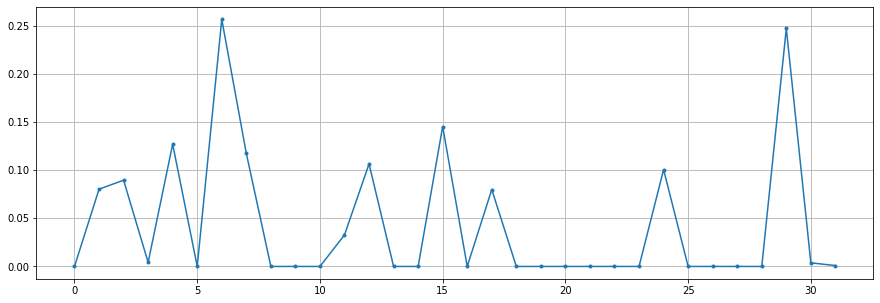

In [1284]:
idx = np.random.choice(300000, 1)[0]

# Visualize code_past
plt.figure(figsize=(15,5))
plt.plot(code_past_all[idx], '.-')
plt.grid()

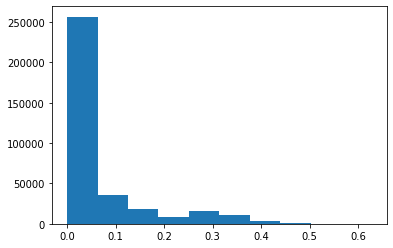

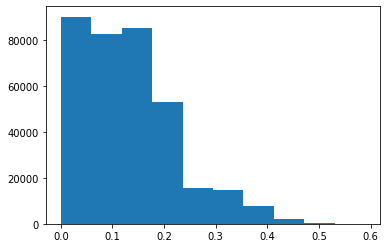

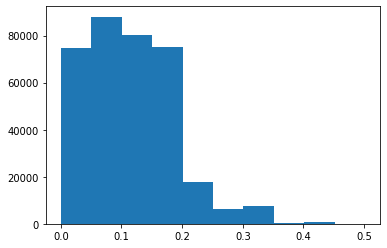

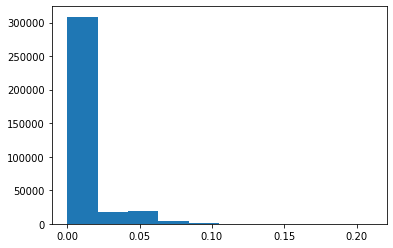

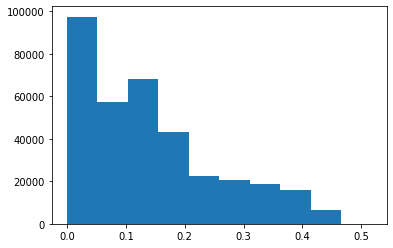

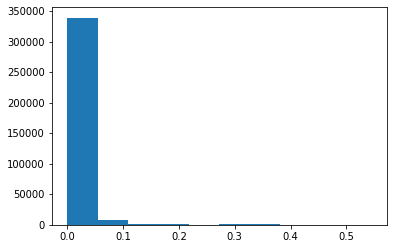

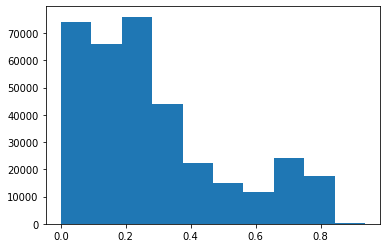

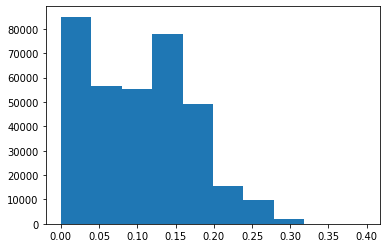

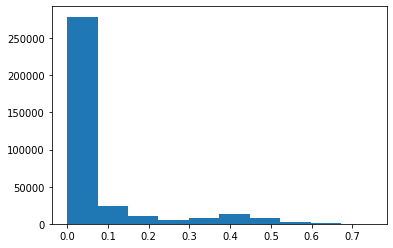

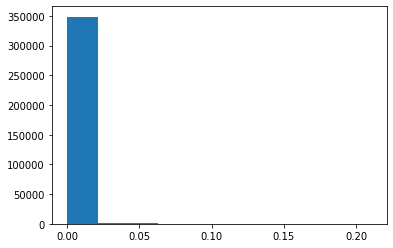

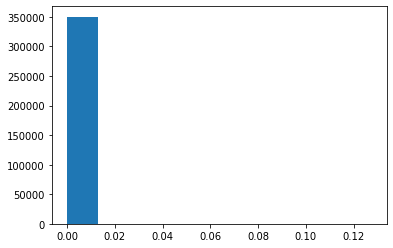

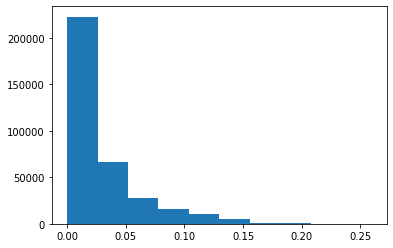

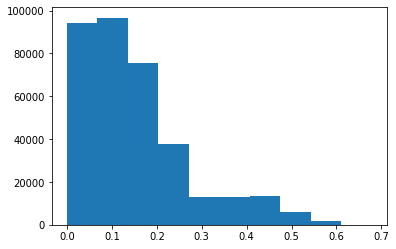

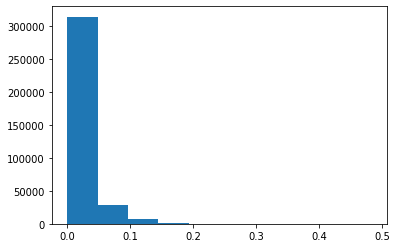

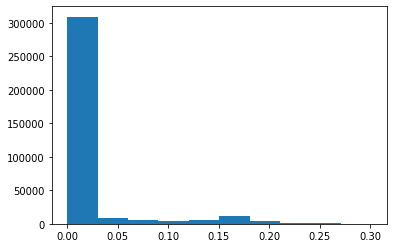

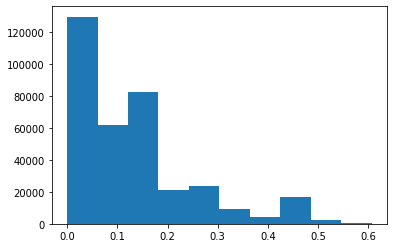

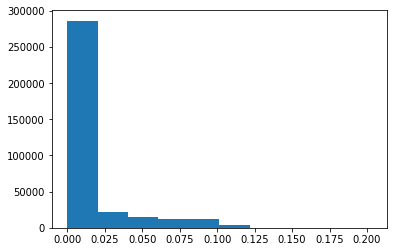

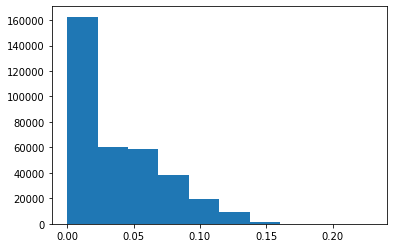

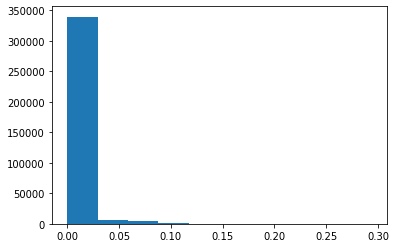

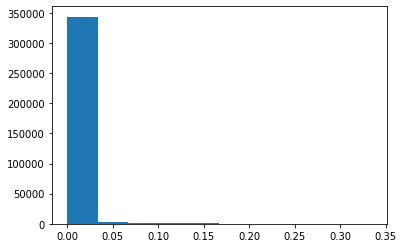

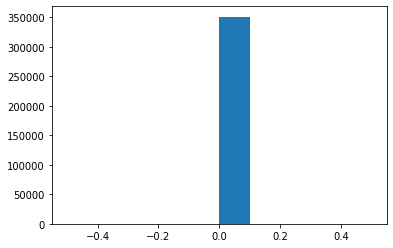

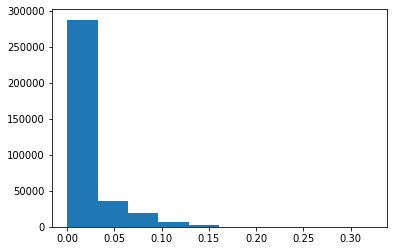

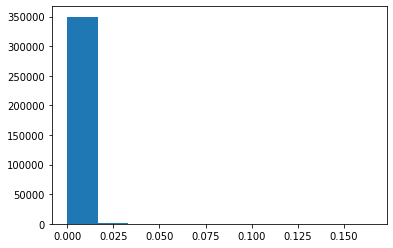

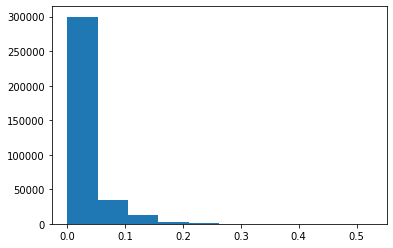

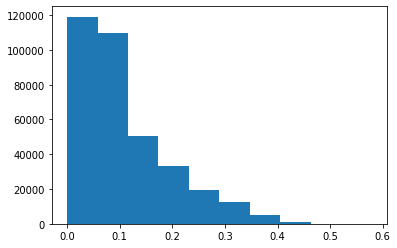

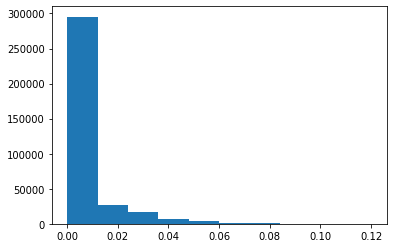

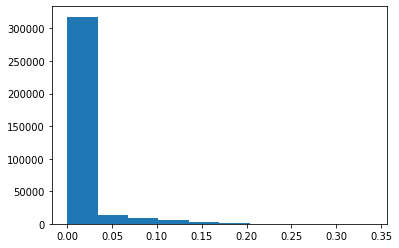

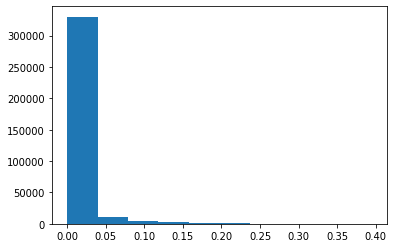

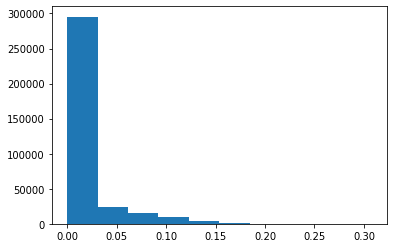

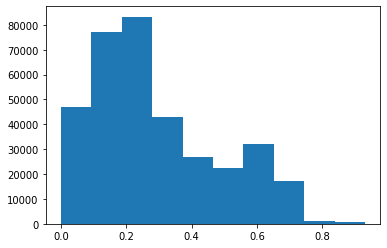

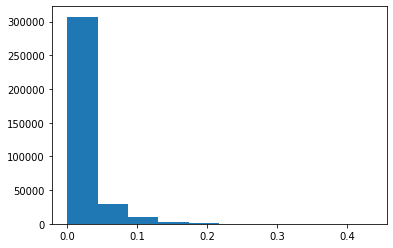

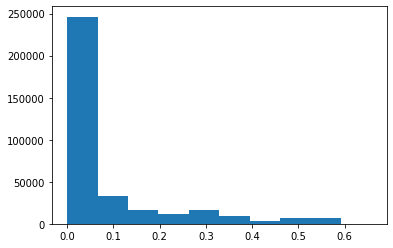

In [1239]:
for i in range(32):
    plt.hist(code_past_all[:,i])
    plt.show()